In [106]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import torchinfo 

import einops

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#load FashionMNIST
train_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"len train set: {len(train_set)}\nlen test set: {len(test_set)}")
print(f"image shape: {train_set[0][0][0].shape}")

len train set: 60000
len test set: 10000
image shape: torch.Size([28, 28])


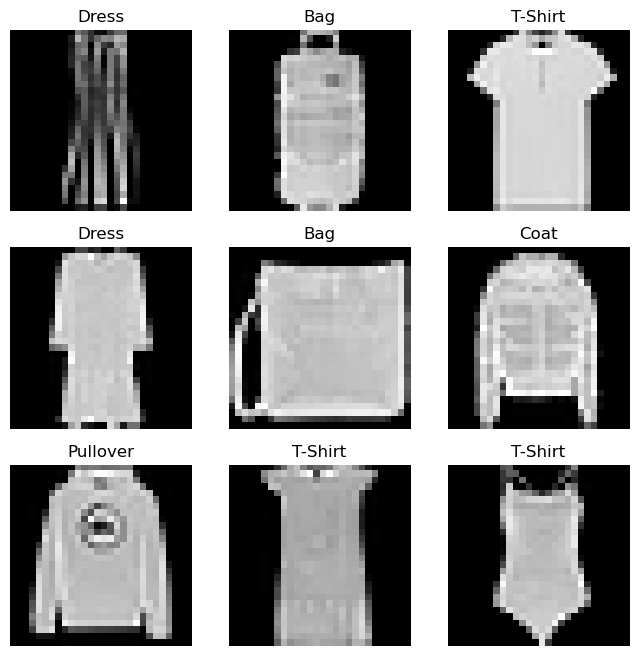

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap="gray") 
plt.show()


In [5]:
#initialize parameters
batch_size = 100

# def device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size)

In [7]:
##### ENCODER BLOCK #####

class EncoderBlock(nn.Module):
    def __init__(self, n_channels, channels, act = nn.LeakyReLU):
        super(EncoderBlock, self).__init__()

        self.in_channels = [n_channels] + list(channels[:-1])
        self.out_channels = list(channels)
        
        self.act = act
        
        self.blocks = nn.ModuleList()
        for i in range(len(self.in_channels) - 1):
            self.blocks.append(nn.Sequential(
                            nn.Conv2d(self.in_channels[i], self.out_channels[i], kernel_size = 3, stride=2, padding=1),
                            nn.BatchNorm2d(self.out_channels[i]),
                            self.act(),
                            nn.Conv2d(self.out_channels[i], self.out_channels[i], kernel_size = 3, stride=1, padding = "same"),
                            nn.BatchNorm2d(self.out_channels[i]),
                            self.act()
                            ))
        self.blocks.append(nn.Sequential(
                        nn.Conv2d(self.in_channels[-1], self.out_channels[-1], kernel_size = 3, stride=2, padding = 1),
                        nn.BatchNorm2d(self.out_channels[-1]),
                        self.act(),
                        nn.Conv2d(self.out_channels[-1], self.out_channels[-1], kernel_size = 3, stride=1, padding = "same"),
                        nn.BatchNorm2d(self.out_channels[-1]),
                        ))  
        
    def forward(self, x):
       
        for block in self.blocks:
            x = block(x)
        
        return x

##### DECODER BLOCK #####

class DecoderBlock(nn.Module):
    def __init__(self, n_channels, channels, act = nn.LeakyReLU):
        super(DecoderBlock, self).__init__()

        reverse_channels = list(channels)
        reverse_channels.reverse()
        
        self.in_channels = reverse_channels
        self.out_channels = reverse_channels[1:] + [n_channels]
        
        self.blocks = nn.ModuleList()
        for i in range(len(self.in_channels)):
            self.blocks.append(nn.Sequential(
                            nn.ConvTranspose2d(self.in_channels[i], self.out_channels[i], kernel_size = 2, stride=2, padding = 0),
                            nn.BatchNorm2d(self.out_channels[i]),
                            act(),
                            nn.Conv2d(self.out_channels[i], self.out_channels[i], kernel_size = 3, stride=1, padding = "same"),
                            nn.BatchNorm2d(self.out_channels[i]),
                            act()
                            ))
    def forward(self, x):
        
        for block in self.blocks:
            x = block(x)
        return x
        
        

In [91]:
class VAE(nn.Module):
    def __init__(self, batch_size, n_channels, channels, latent_dim):
        super(VAE, self).__init__()

        self.batch_size = batch_size
        self.n_channels = n_channels
        self.channels = channels

        self.r = len(channels) #reduction factor (nb of conv blocks)
        self.latent_dim = latent_dim

        self.encoder = EncoderBlock(n_channels, channels)
        
        self.mu = nn.Linear(channels[-1]*(28//(2**self.r))**2, self.latent_dim)
        self.sigma = nn.Linear(channels[-1]*(28//(2**self.r))**2, self.latent_dim)
        self.decode_linear = nn.Linear(self.latent_dim, channels[-1]*(28//(2**self.r))**2)
        
        self.decoder = DecoderBlock(n_channels, channels)
        
        self.final_conv = nn.Conv2d(self.n_channels, self.n_channels,  kernel_size = 3, padding = "same")

    def _sampling(self, x):
        
        mu = self.mu(x)
        logvar = self.sigma(x)

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps.mul(std), mu, logvar

    def forward(self, x):

        x = self.encoder(x)
        x = einops.rearrange(x, 'b c h w -> b (c h w)')
        
        x, mu, log_var = self._sampling(x)
        
        x = self.decode_linear(x)
        
        x = einops.rearrange(x, 'b (c h w) -> b c h w', h = 28//(2**self.r), w = 28//(2**self.r))

        x = self.decoder(x)

        x = self.final_conv(x)
        return x, mu, log_var   
        

In [141]:
class VectorQuantizer(nn.Module):
    def __init__(self, n_embedding, embedding_dim, beta = 0.5, device ='cpu'):
        super(VectorQuantizer, self).__init__()

        self.K = n_embedding
        self.embedding_dim = embedding_dim

        self.beta = beta
        
        self.embedding = nn.Embedding(self.K, self.embedding_dim).to(device)
        self.embedding.weight.data.uniform_(-1/n_embeddings, 1/n_embeddings) #https://huggingface.co/blog/ariG23498/understand-vq

    def forward(self, x):

        _ , _ , height, weight = x.shape
        x_e = einops.rearrange(x, "b d h w -> (b h w) d")

        distances = ((self.embedding.weight[:, None, :] - x_e[None, :, :]) ** 2).sum(dim = -1)
        e_indices =  torch.argmin(distances, dim = 0)

        x_q = self.embedding.weight[e_indices] #representation of x in the embedding space
        x_q = einops.rearrange(x_q, "(b h w) d -> b d h w", h = height, w = weight)

        loss = F.mse_loss(x_q, x.detach()) + self.beta * F.mse_loss(x_q.detach(), x)

        # estimator trick
        x_q = x + (x_q - x).detach()

        return x_q, loss         

        

In [143]:
class VQVAE(nn.Module):
    def __init__(self, batch_size, n_channels, channels, n_embedding):
        super(VQVAE, self).__init__()

        self.batch_size = batch_size
        self.n_channels = n_channels
        self.channels = channels

        self.r = len(channels) #reduction factor (nb of conv blocks)
        self.n_embedding = n_embedding

        self.encoder = EncoderBlock(n_channels, channels)
        self.vq = VectorQuantizer(n_embedding, channels[-1])
        
        self.decoder = DecoderBlock(n_channels, channels)
        
        self.final_conv = nn.Conv2d(self.n_channels, self.n_channels,  kernel_size = 3, padding = "same")

    def forward(self, x):

        x = self.encoder(x)
        x, vq_loss = self.vq(x)
        x = self.decoder(x)

        x = self.final_conv(x)
        return x, vq_loss
        

In [144]:
# training params
n_epochs = 10
lr = 1e-3

n_channels = 1
channels = (64,128)
latent_dim = 20
n_embeddings = 20

In [146]:
vae = VAE(batch_size, n_channels, channels, latent_dim).to(device)
    vqvae = VQVAE(batch_size, n_channels, channels, n_embeddings).to(device)

print("==========\nVAE: \n==========\n")
print(torchinfo.summary(vae, (1, 1, 28,28), device = str(device)))

print("==========\nVQVAE: \n==========\n")
print(torchinfo.summary(vqvae, (1, 1, 28,28), device = str(device)))


VAE: 

Layer (type:depth-idx)                        Output Shape              Param #
VAE                                           [1, 1, 28, 28]            --
├─EncoderBlock: 1-1                           [1, 128, 7, 7]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─Sequential: 3-1                   [1, 64, 14, 14]           37,824
│    │    └─Sequential: 3-2                   [1, 128, 7, 7]            221,952
├─Linear: 1-2                                 [1, 20]                   125,460
├─Linear: 1-3                                 [1, 20]                   125,460
├─Linear: 1-4                                 [1, 6272]                 131,712
├─DecoderBlock: 1-5                           [1, 1, 28, 28]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─Sequential: 3-3                   [1, 64, 14, 14]           70,016
│    │    └─Sequential: 3-4                   [1, 1, 28, 28]

In [153]:
#Loss definition
def vae_loss(reconstructed_x, x, mu, logvar):
    
    BCE = nn.functional.binary_cross_entropy_with_logits(reconstructed_x, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_divergence

def vqvae_loss(reconstructed_x, x, vq_loss):

    reconstruction_loss = F.mse_loss(reconstructed_x, x)
    
    return reconstruction_loss + vq_loss


In [149]:
#training loop
def train_vae(model, train_loader, epochs=10, lr=1e-3, device=device):
    model.train()  
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, label = data
            x = x.to(device)
            
            optimizer.zero_grad()
            reconstructed_x, mu, logvar = model(x)
        
            loss = vae_loss(reconstructed_x, x, mu, logvar)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

def evaluate_vae(model, eval_loader, device='cuda'):
    model.eval() 
    
    with torch.no_grad():
        for data in eval_loader:
            x, label = data
            x = x.to(device)
            
            reconstructed_x, mu, logvar = model(x)
            
            reconstructed_x = reconstructed_x.cpu()
            x = x.cpu()
            
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(x[0].squeeze(), cmap='gray')
            axes[0].set_title("Original Image")
            axes[1].imshow(reconstructed_x[0].squeeze(), cmap='gray')
            axes[1].set_title("Reconstructed Image")
            plt.show()


In [150]:
train_vae(vae, train_loader, epochs=n_epochs, lr=lr, device=device)

Epoch 1/10:  65%|████████████████████████████████████████████▊                        | 390/600 [00:06<00:03, 59.56it/s]


KeyboardInterrupt: 

In [ ]:
evaluate_vae(vae, test_loader, device=device)

In [156]:
#training loop
def train_vqvae(model, train_loader, epochs=10, lr=1e-3, device=device):
    model.train()  
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, label = data
            x = x.to(device)
            
            optimizer.zero_grad()
            reconstructed_x, vq_loss = model(x)
        
            loss = vqvae_loss(reconstructed_x, x, vq_loss)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

def evaluate_vqvae(model, eval_loader, device='cuda'):
    model.eval() 
    
    with torch.no_grad():
        for data in eval_loader:
            x, label = data
            x = x.to(device)
            
            reconstructed_x, _ = model(x)
            
            reconstructed_x = reconstructed_x.cpu()
            x = x.cpu()
            
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(x[0].squeeze(), cmap='gray')
            axes[0].set_title("Original Image")
            axes[1].imshow(reconstructed_x[0].squeeze(), cmap='gray')
            axes[1].set_title("Reconstructed Image")
            plt.show()

In [154]:
train_vqvae(vqvae, train_loader, epochs=n_epochs, lr=lr, device=device)

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 53.77it/s]


Epoch [1/10], Loss: 0.6666


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 56.27it/s]


Epoch [2/10], Loss: 0.0680


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 57.47it/s]


Epoch [3/10], Loss: 0.0358


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 56.81it/s]


Epoch [4/10], Loss: 0.0292


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 56.58it/s]


Epoch [5/10], Loss: 0.0264


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 57.16it/s]


Epoch [6/10], Loss: 0.0247


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 58.29it/s]


Epoch [7/10], Loss: 0.0236


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 58.03it/s]


Epoch [8/10], Loss: 0.0230


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 57.83it/s]


Epoch [9/10], Loss: 0.0219


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 57.67it/s]

Epoch [10/10], Loss: 0.0212


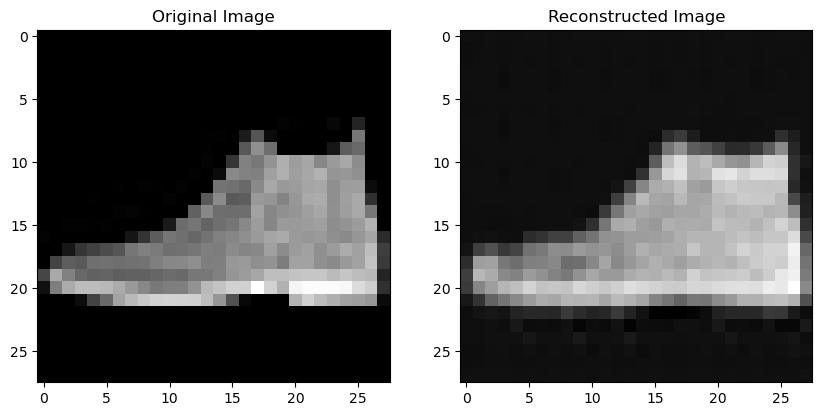

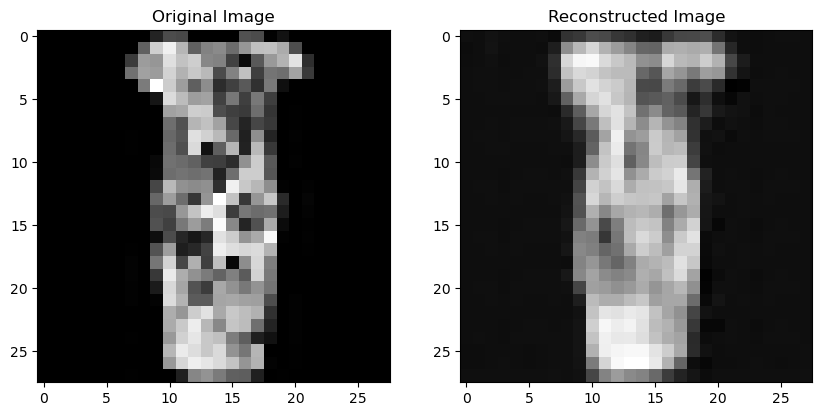

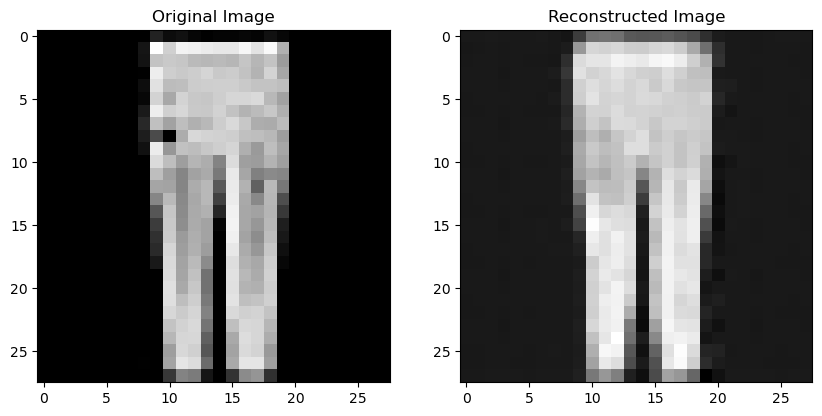

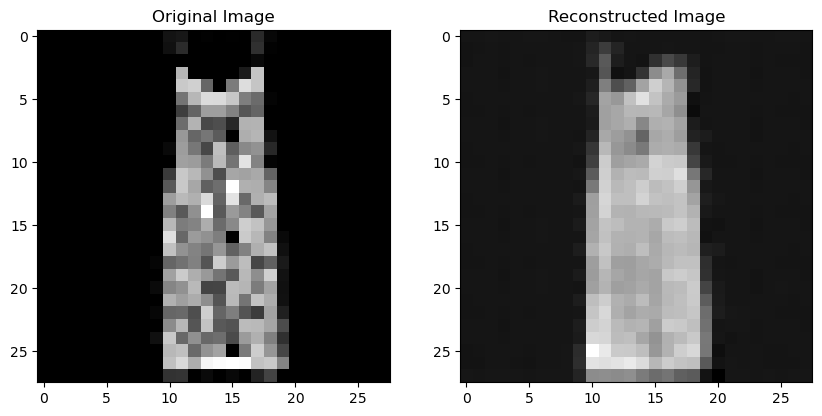

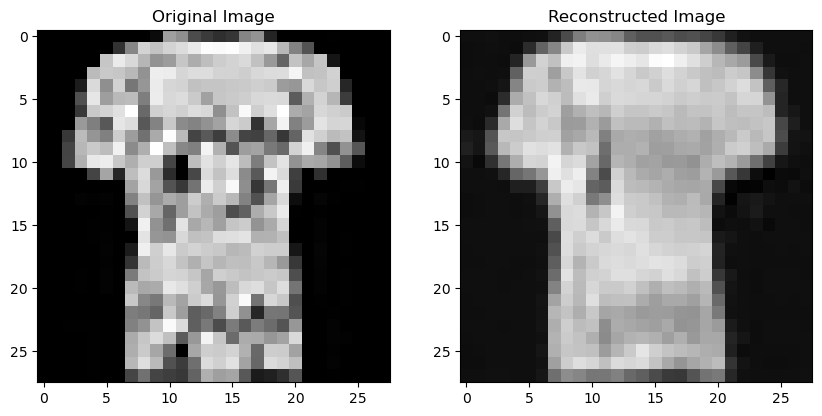

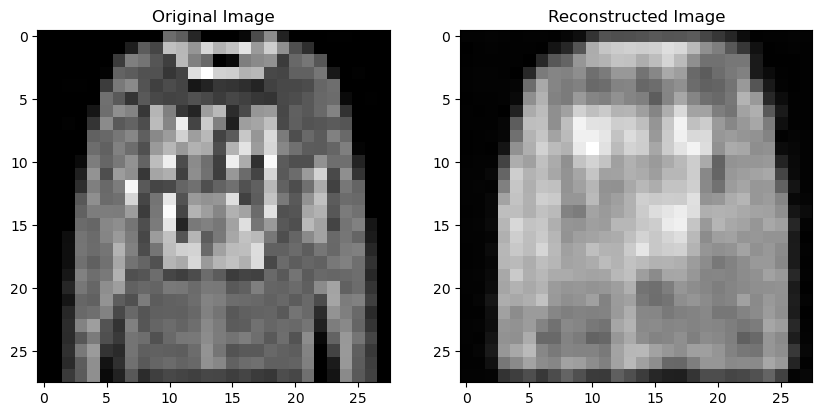

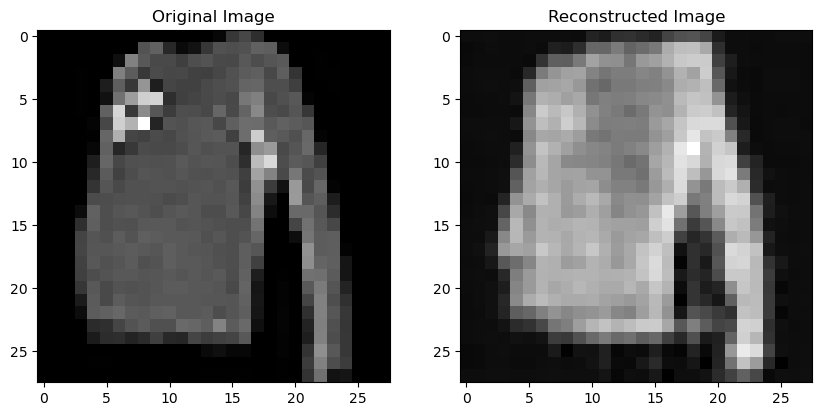

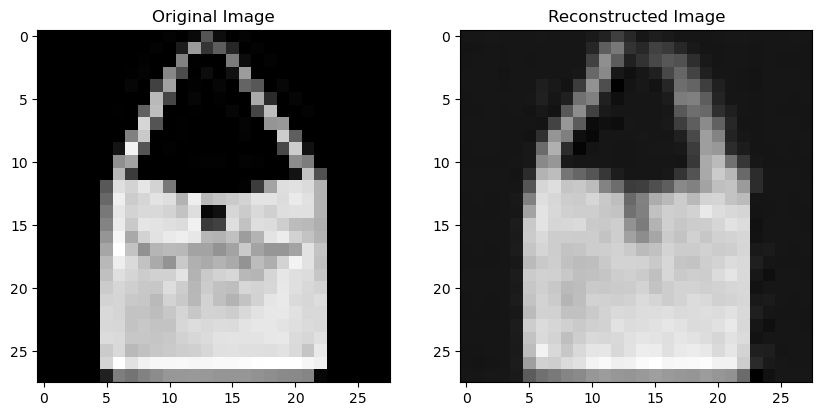

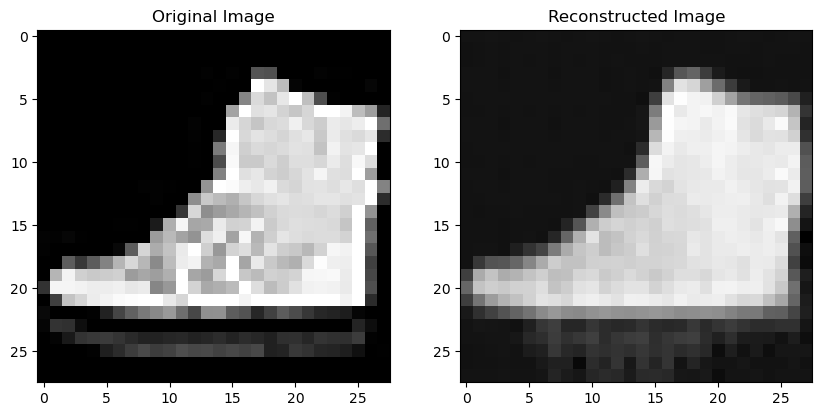

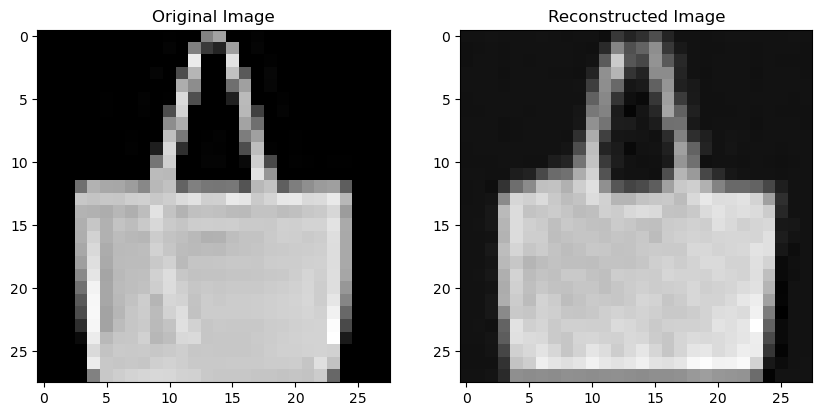

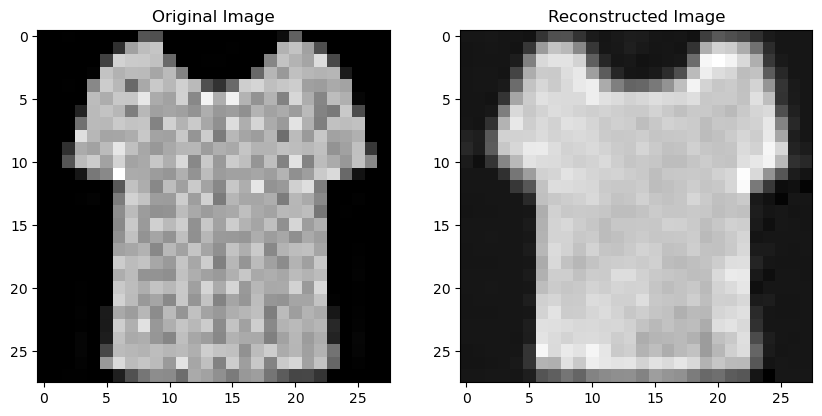

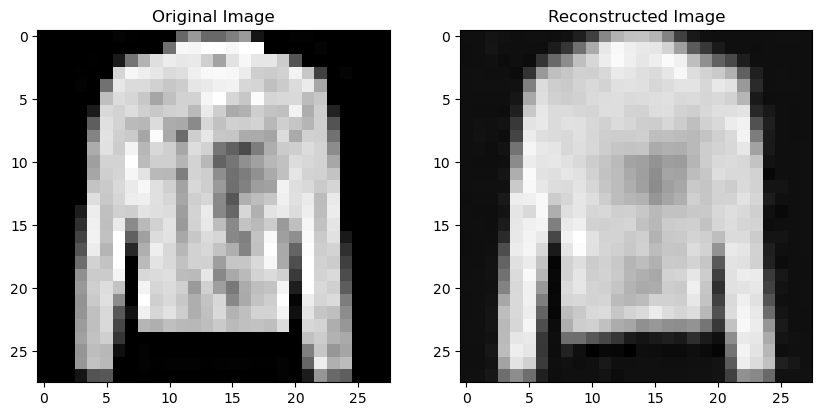

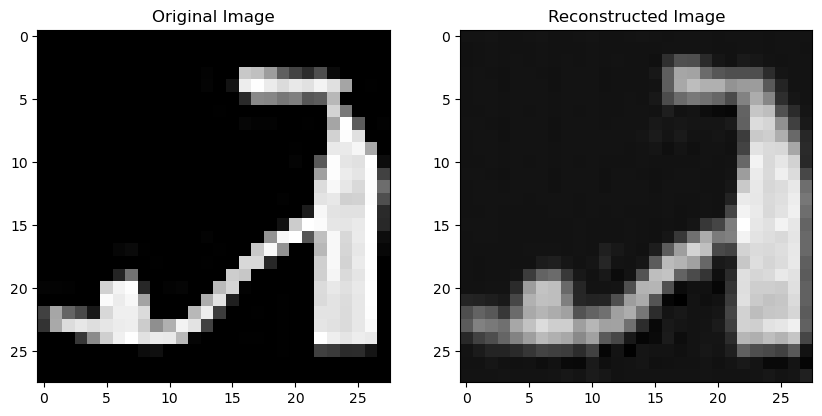

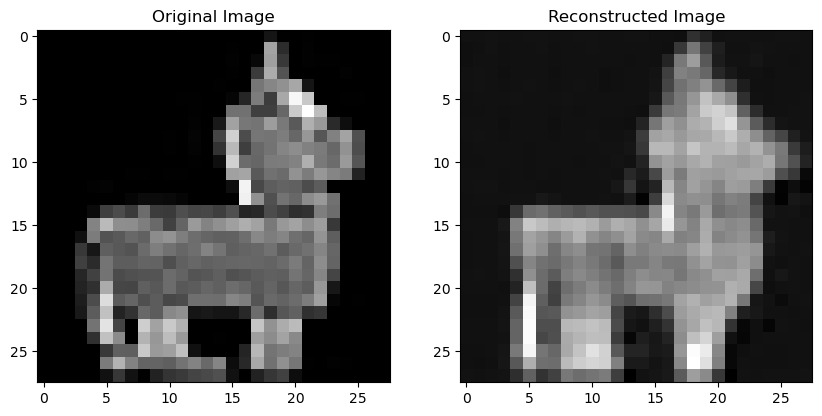

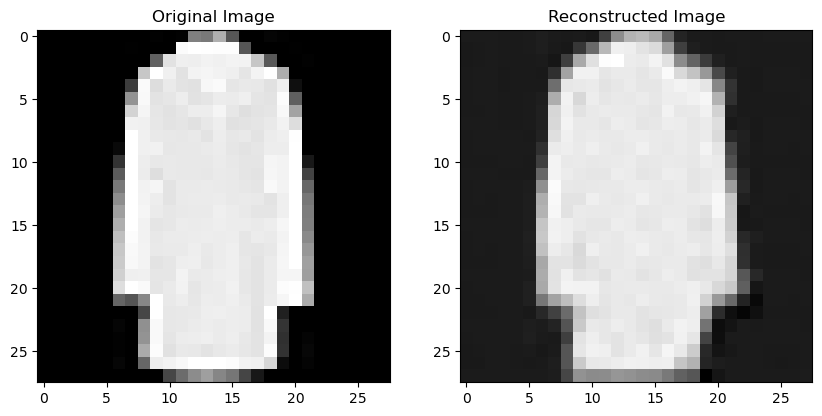

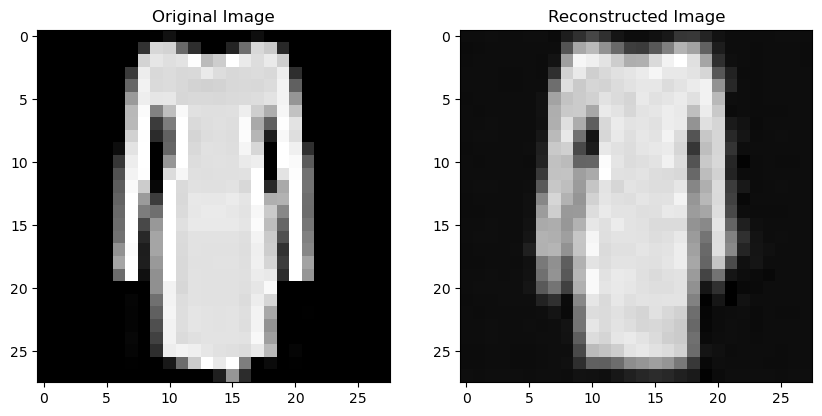

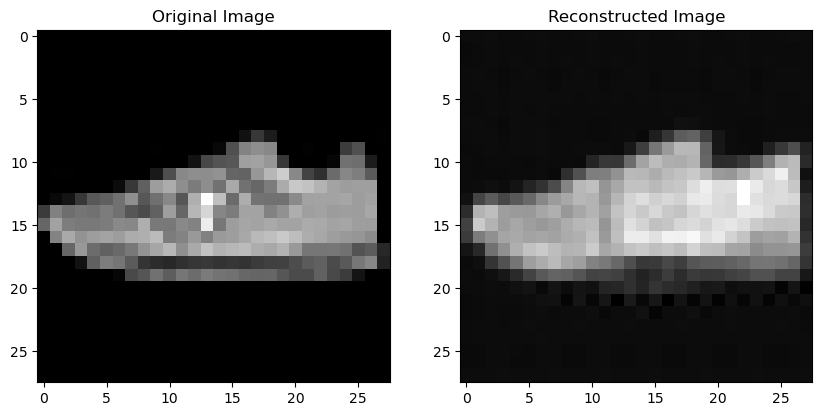

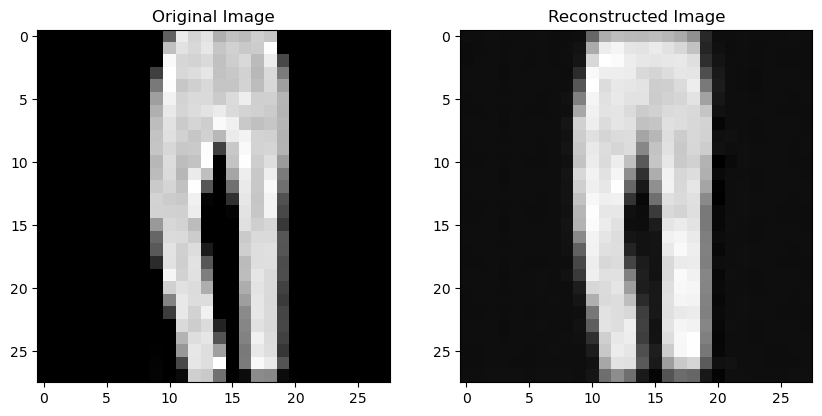

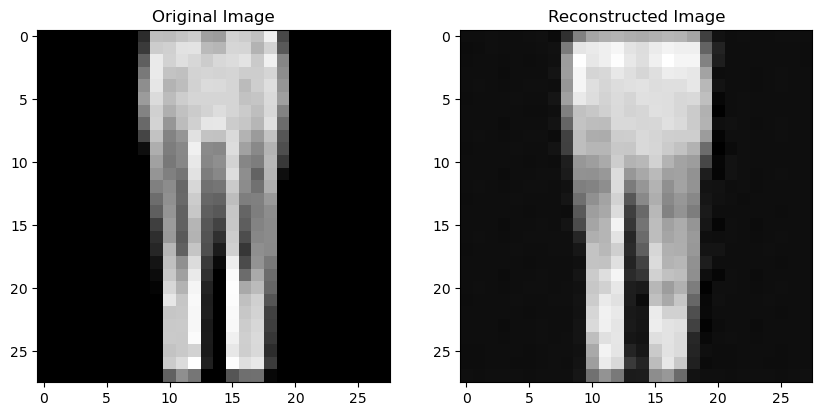

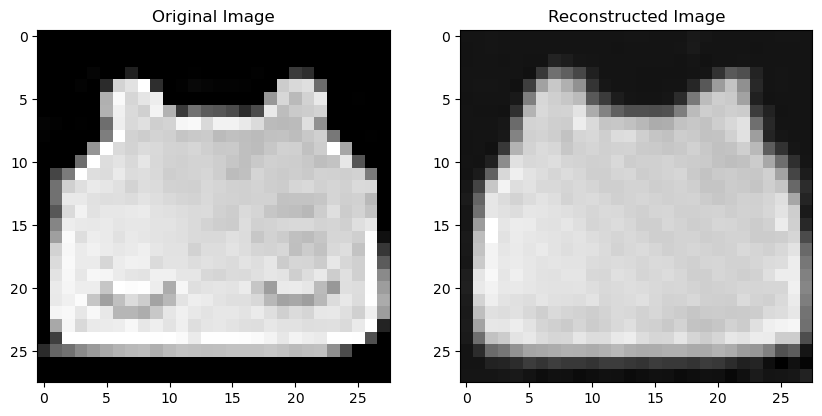

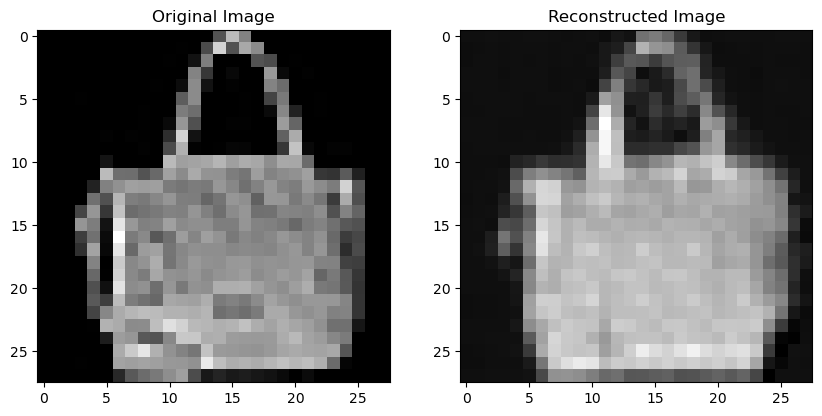

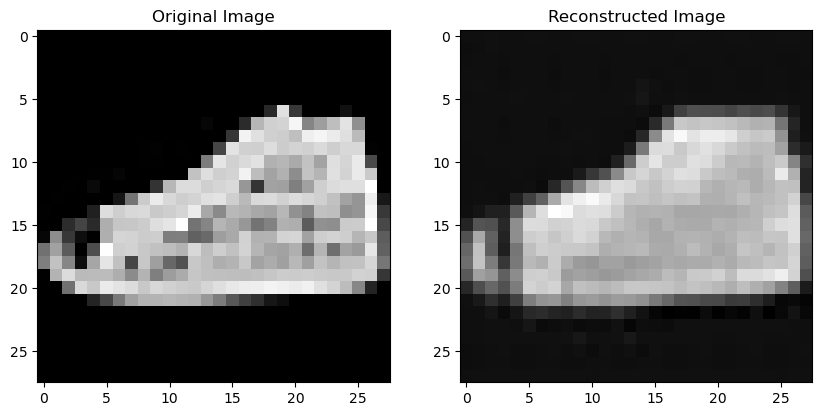

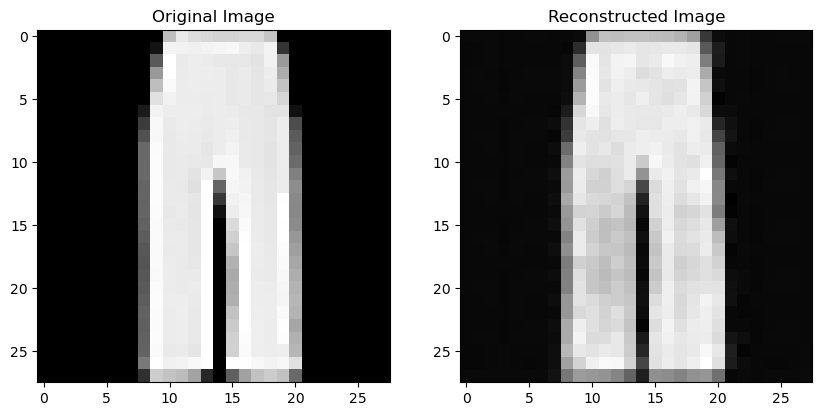

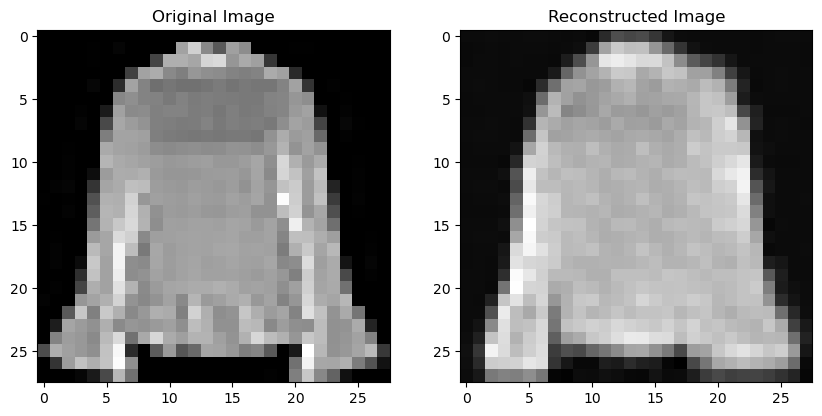

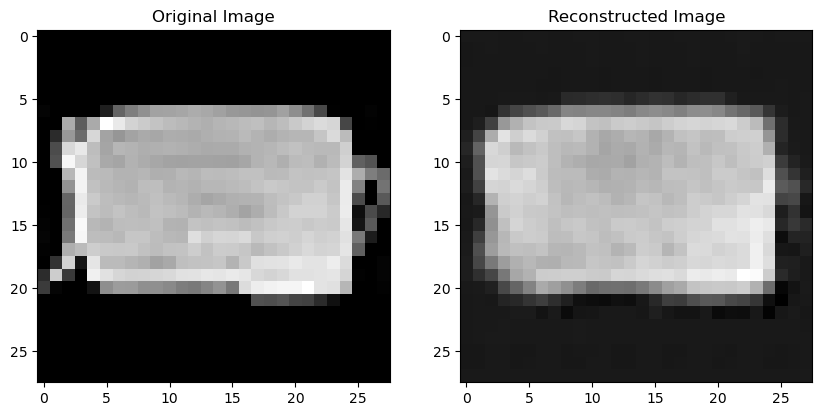

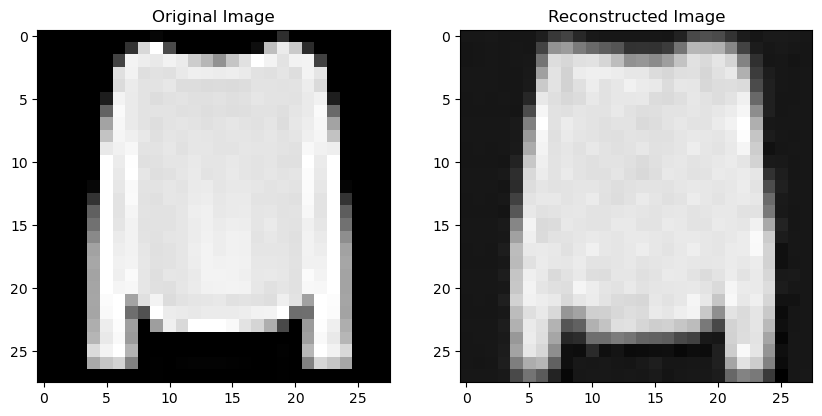

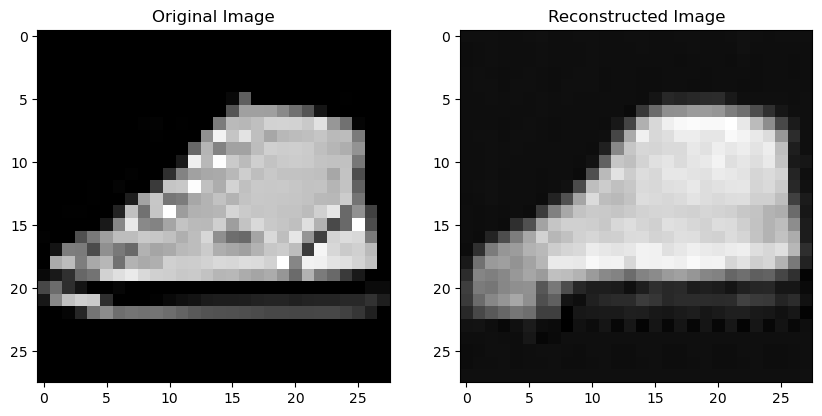

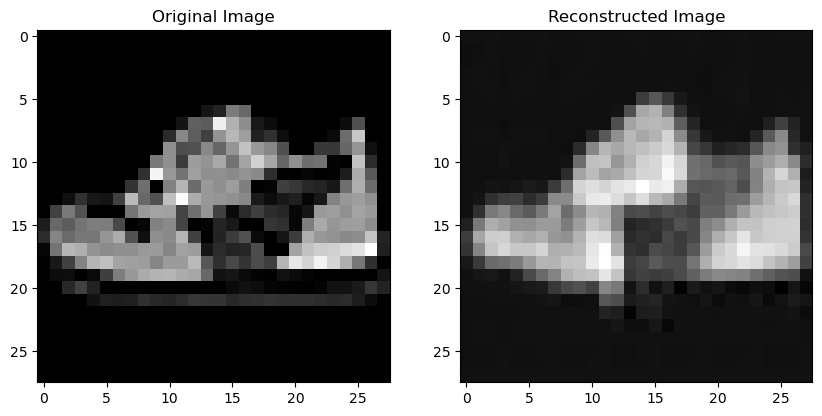

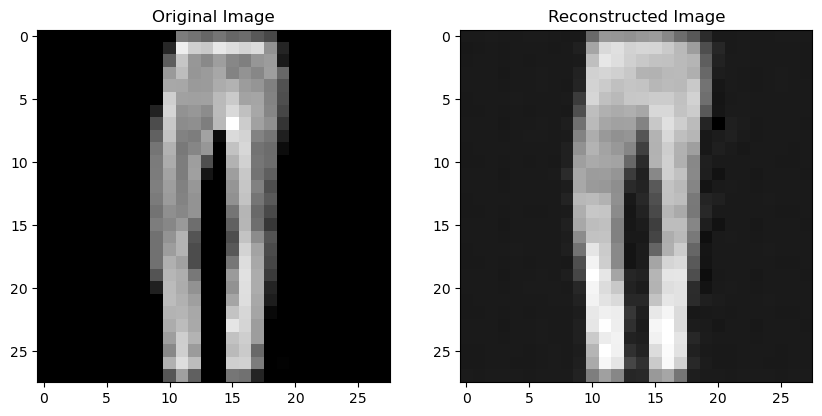

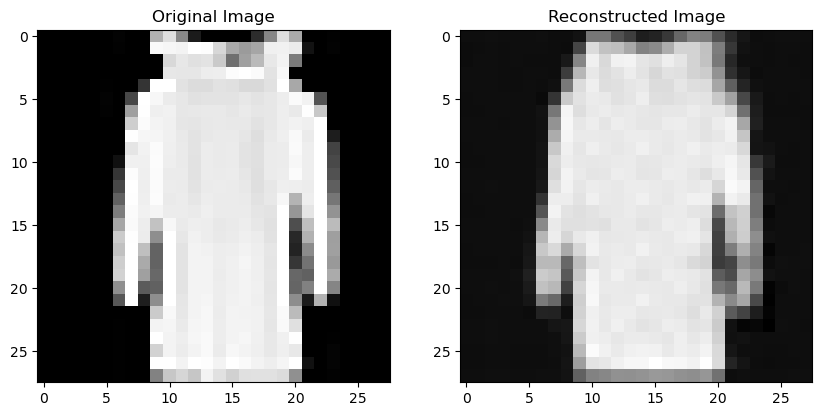

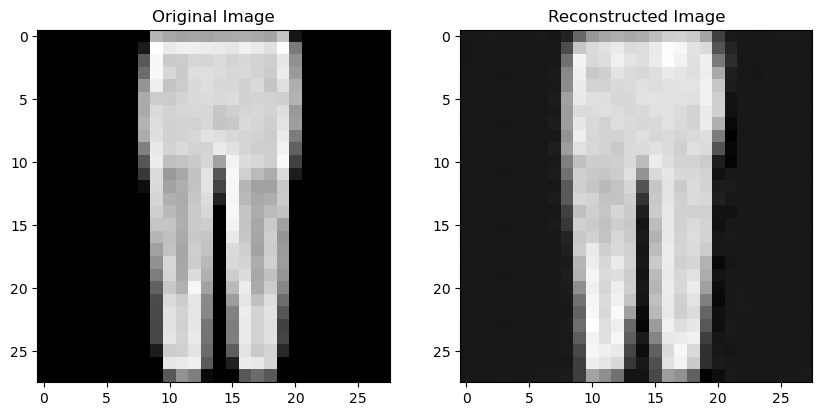

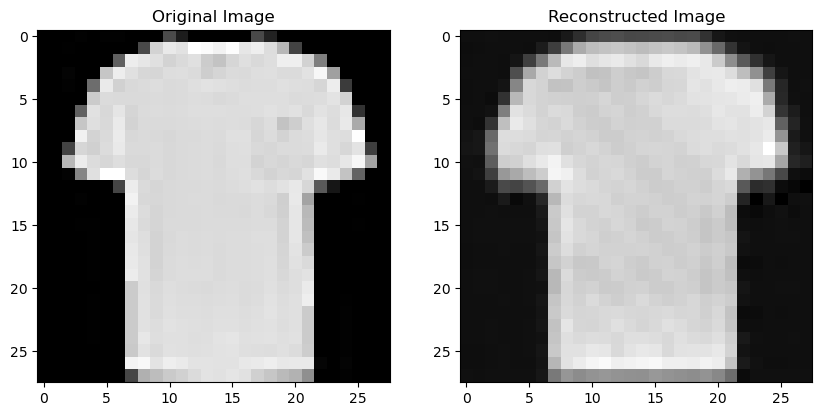

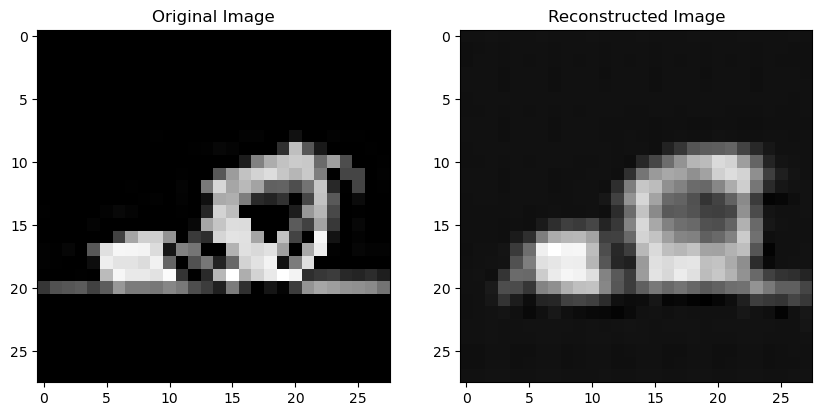

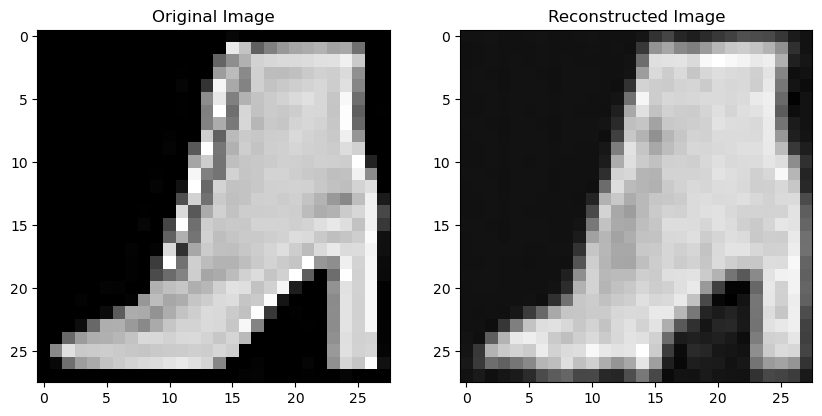

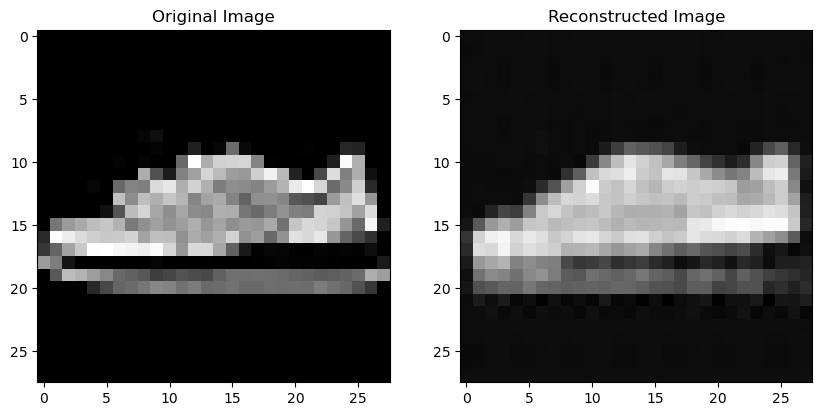

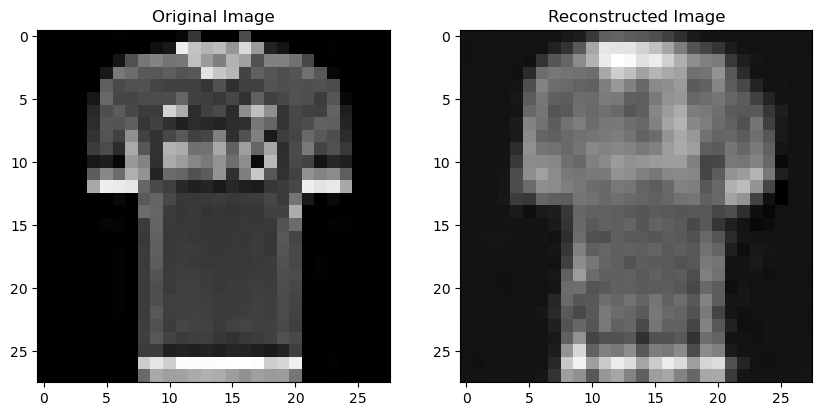

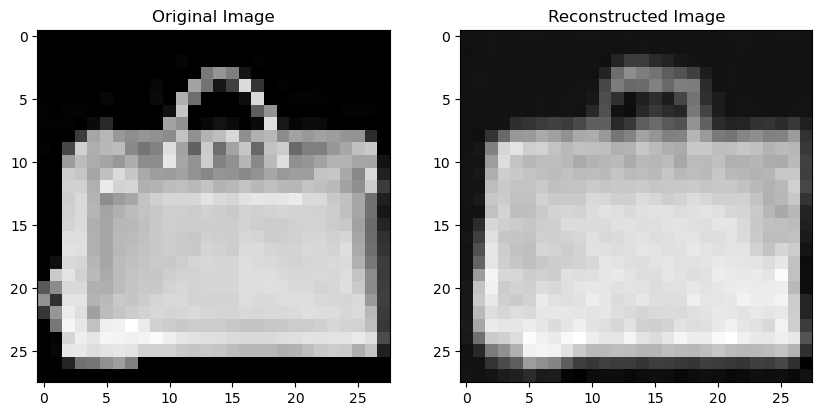

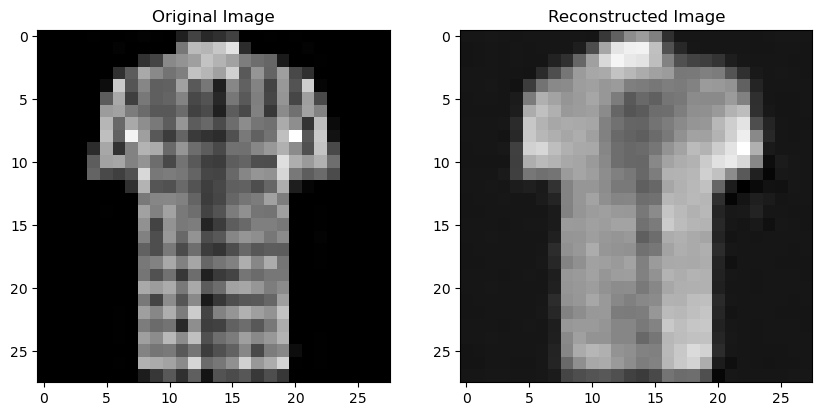

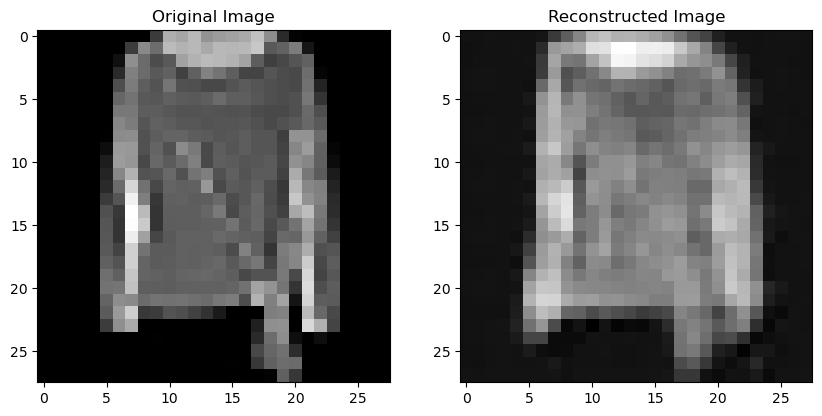

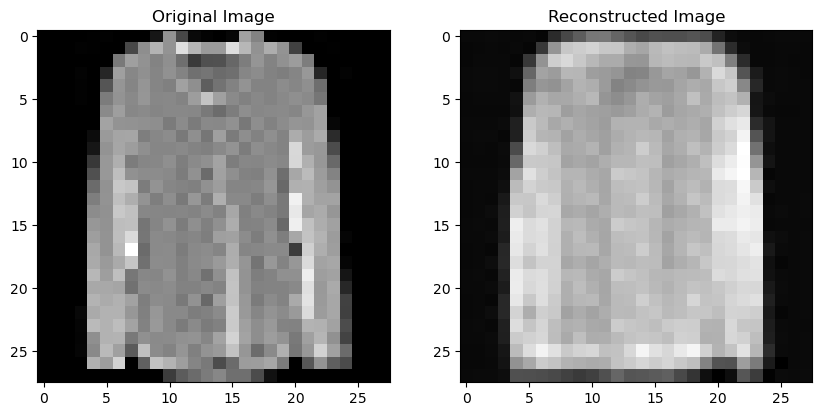

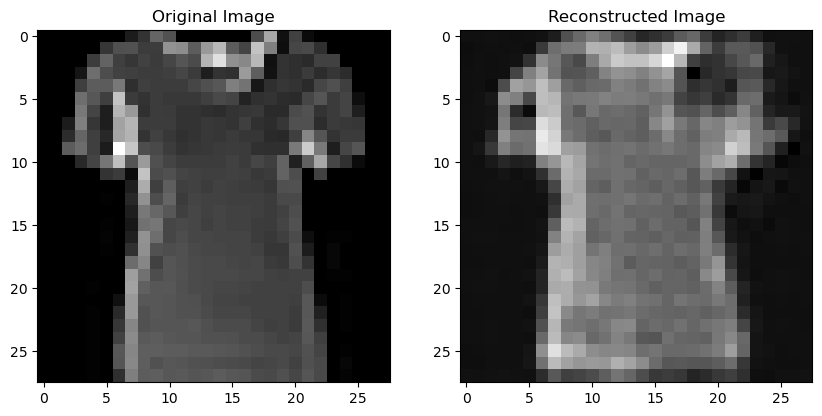

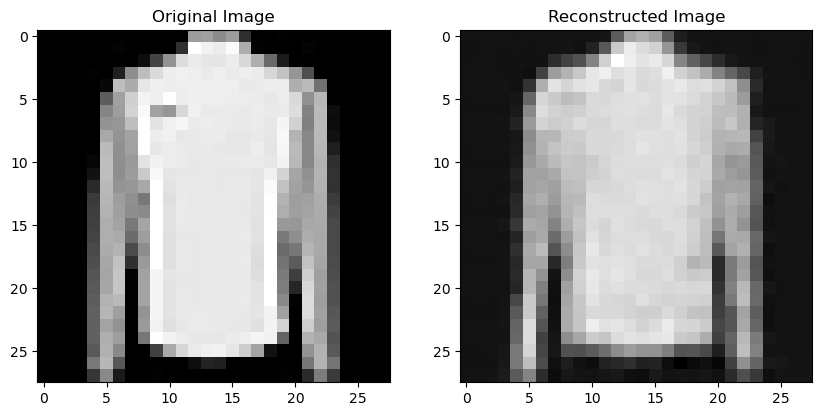

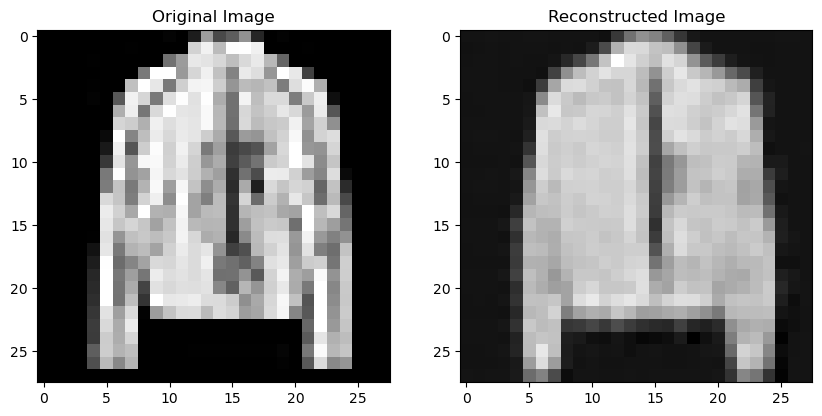

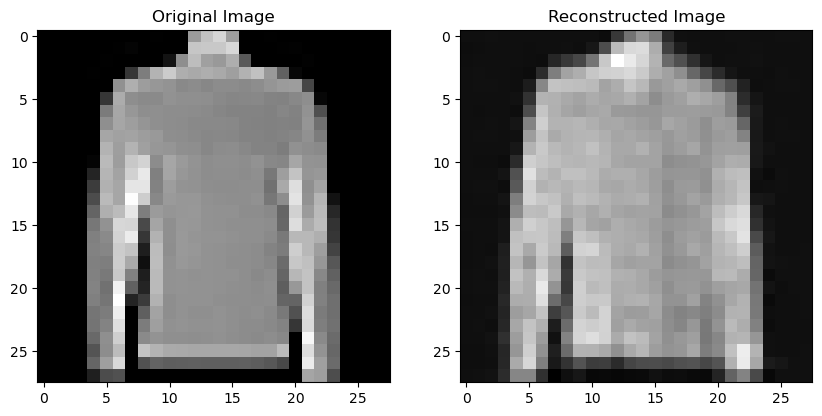

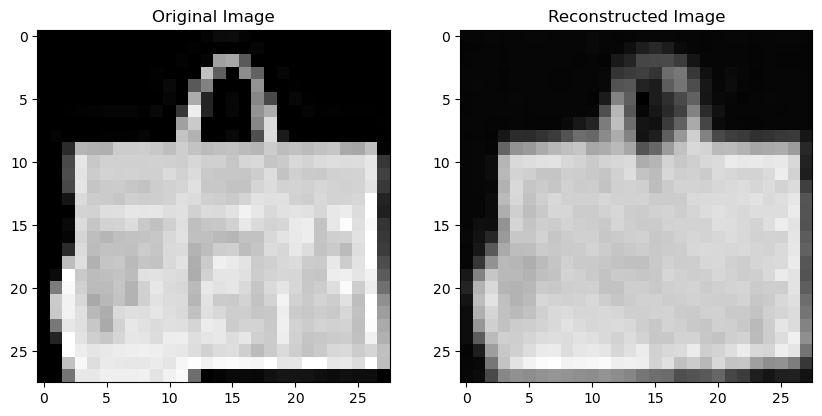

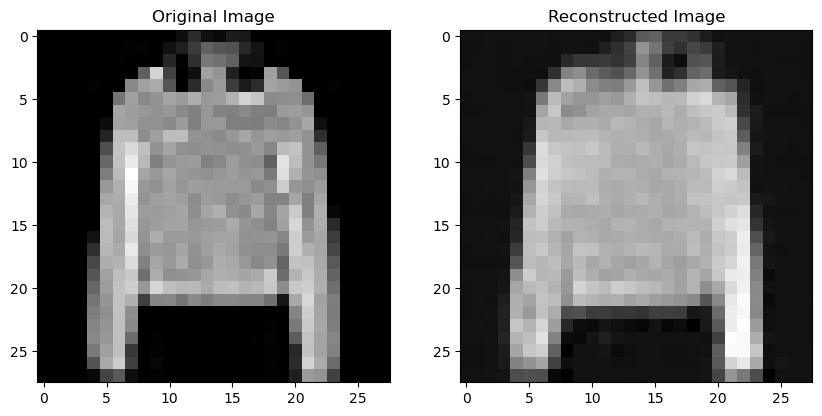

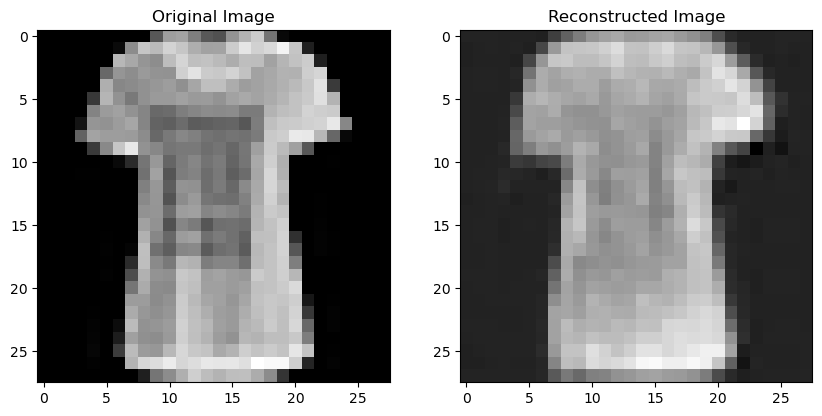

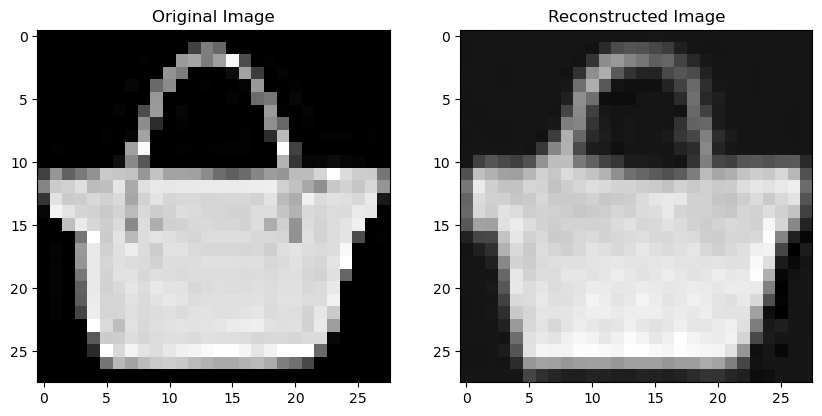

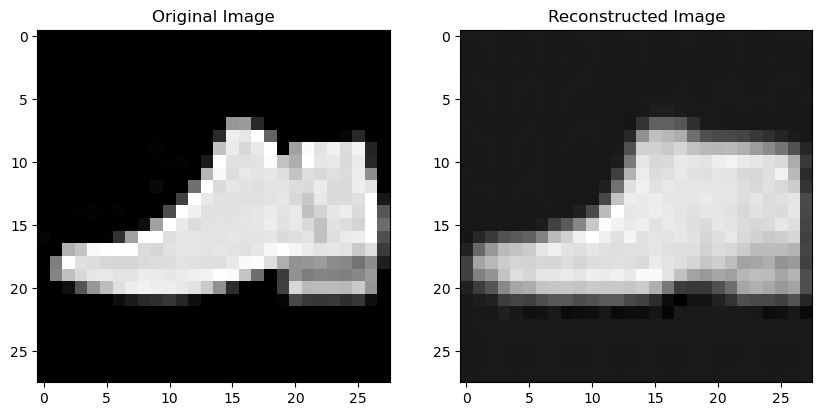

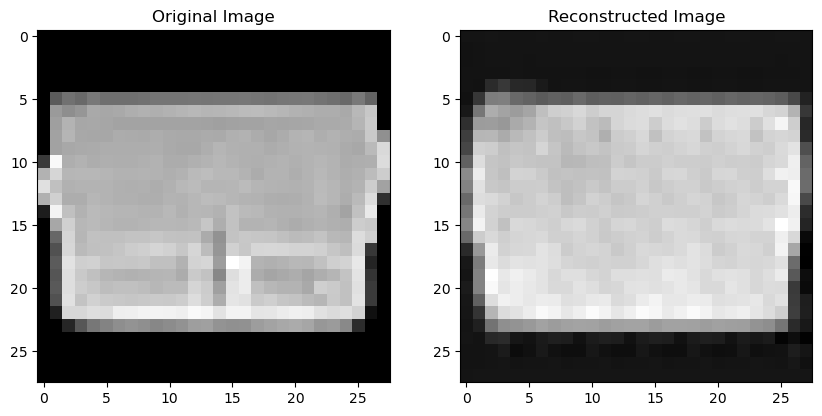

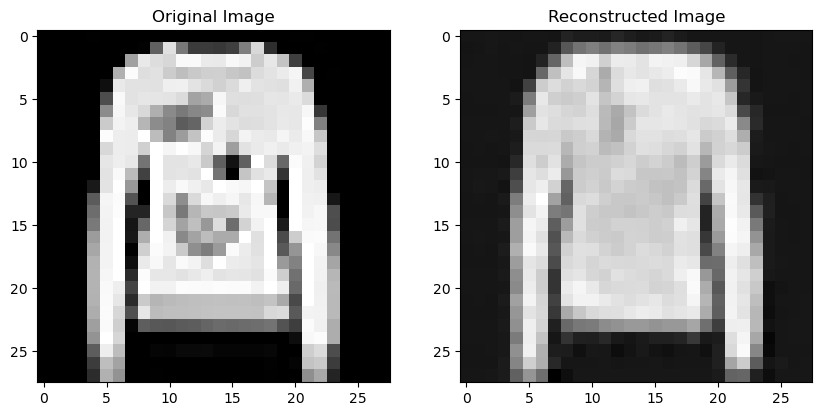

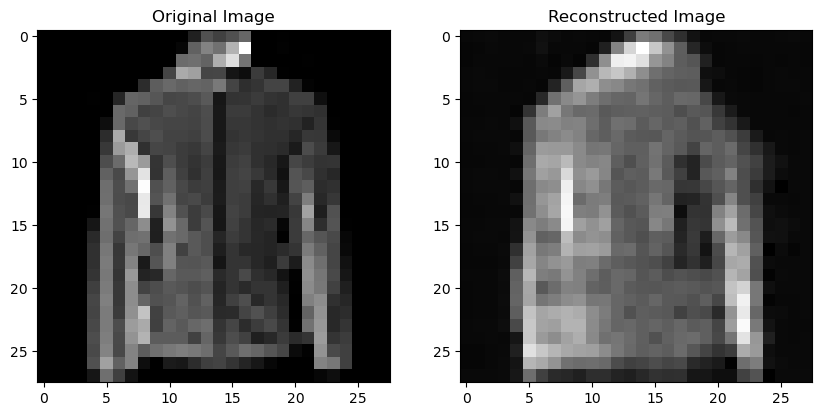

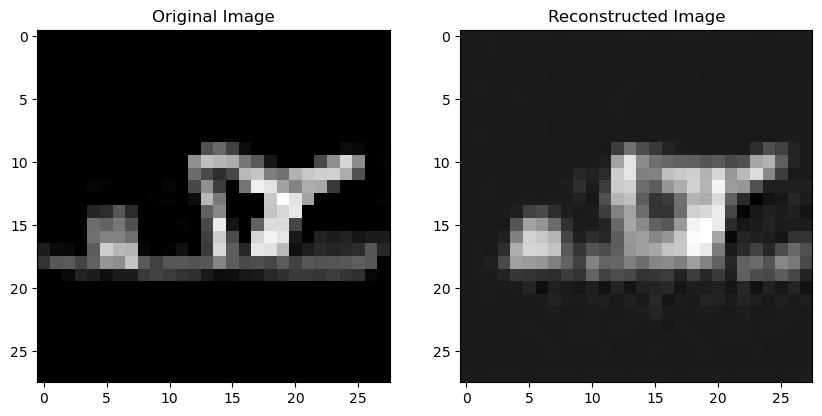

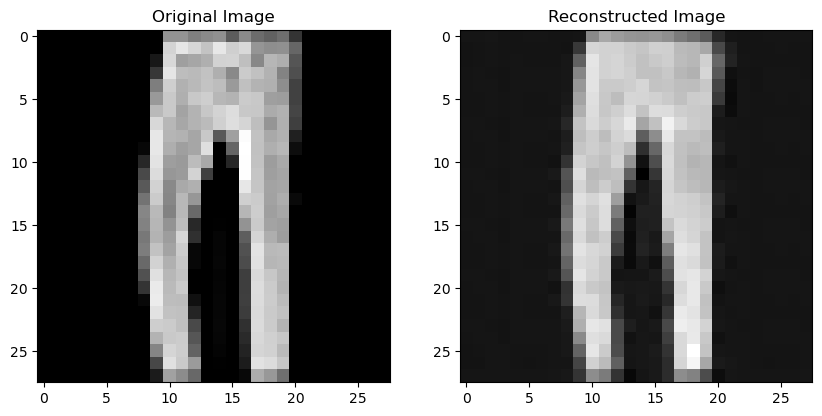

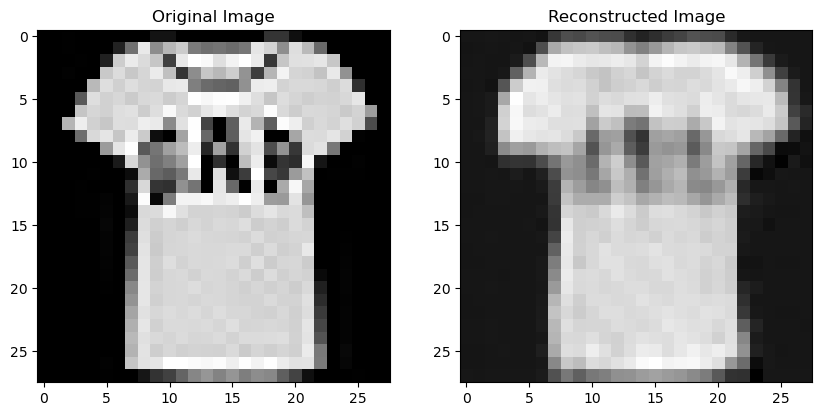

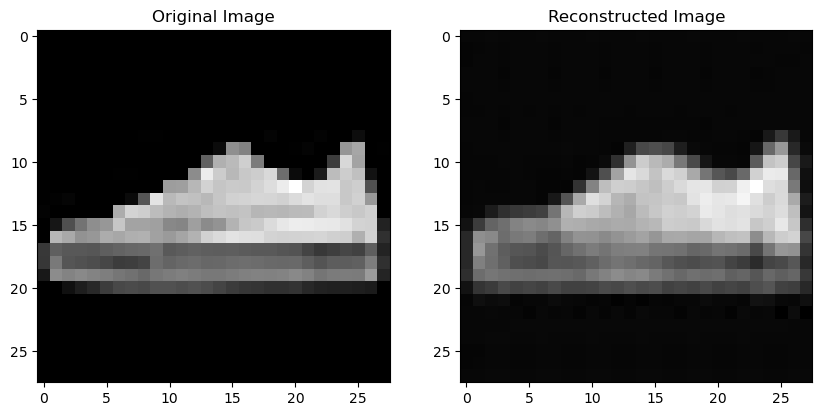

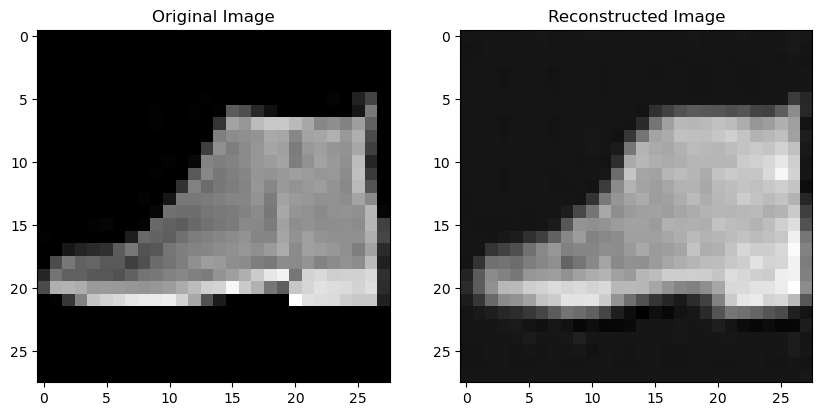

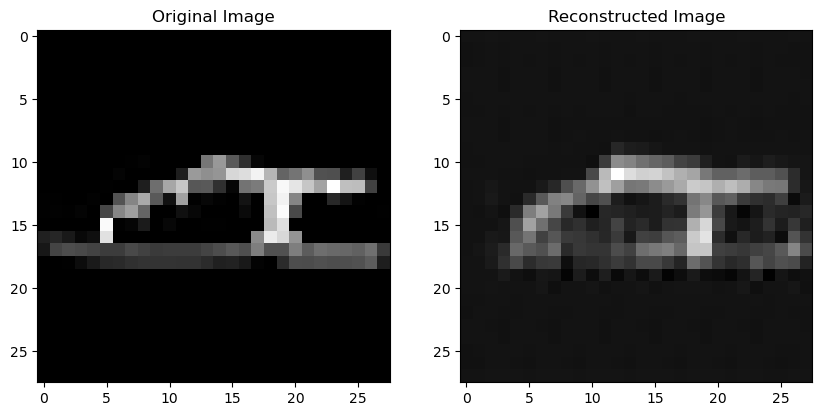

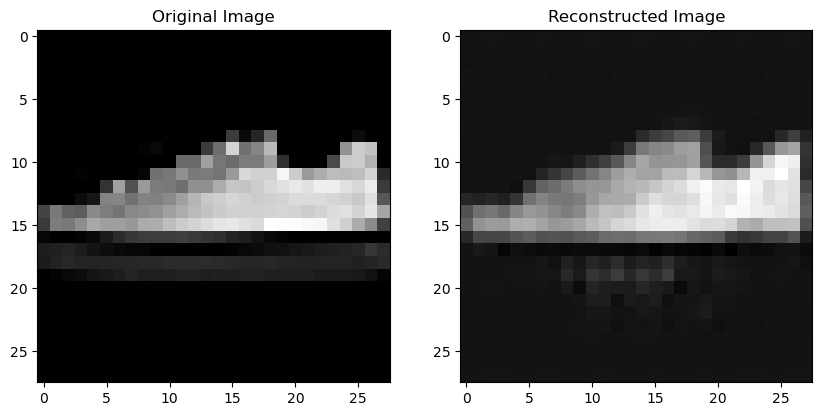

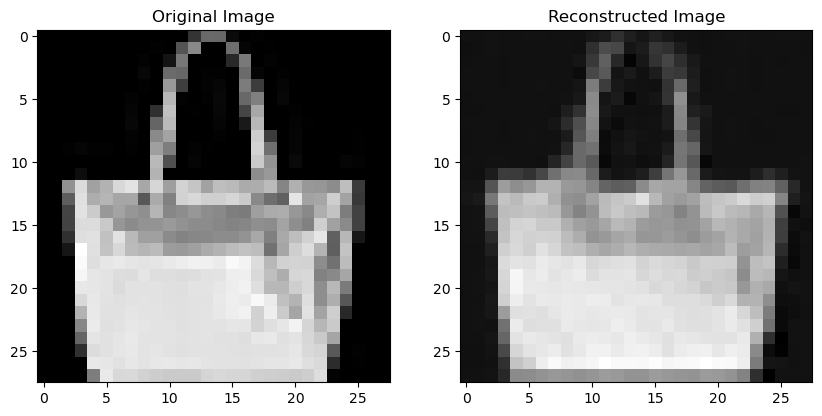

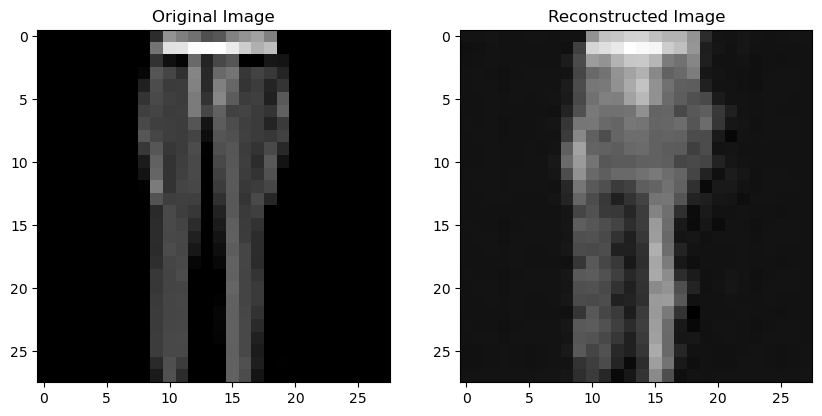

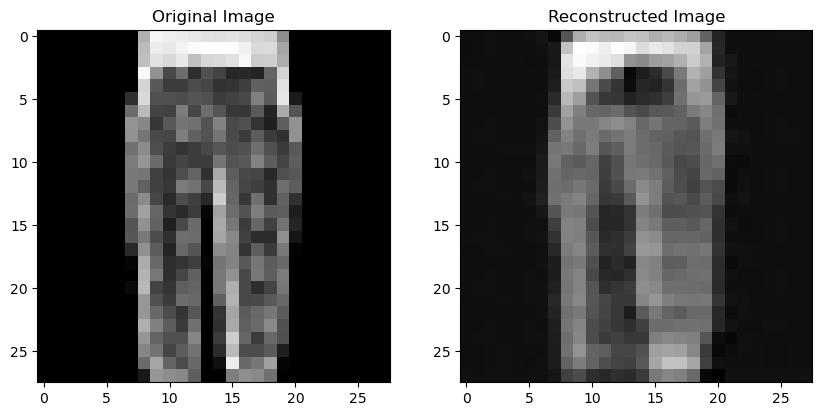

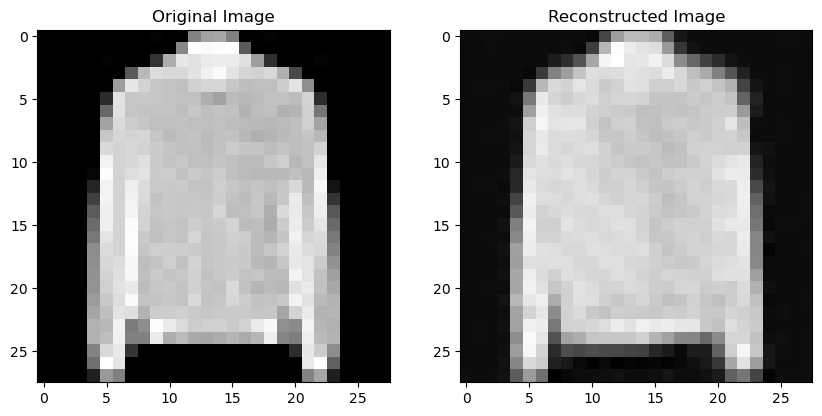

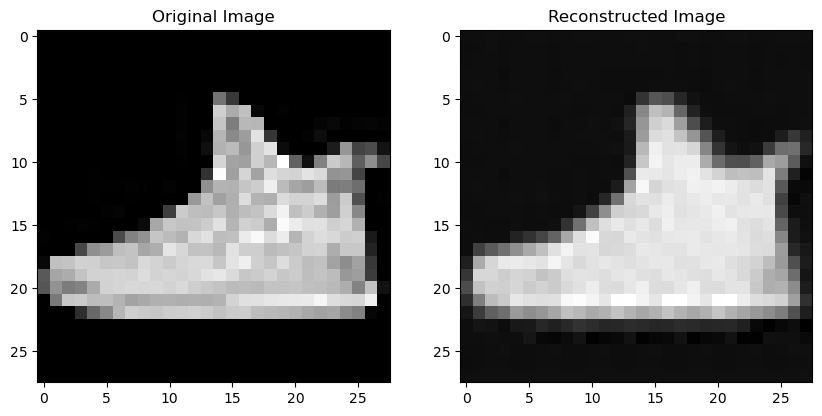

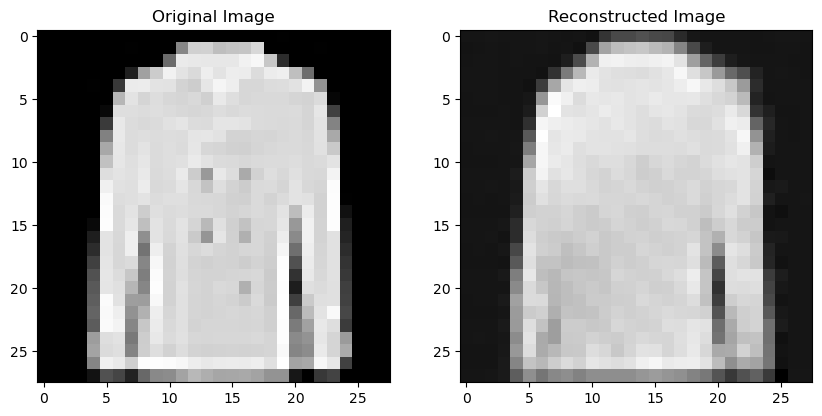

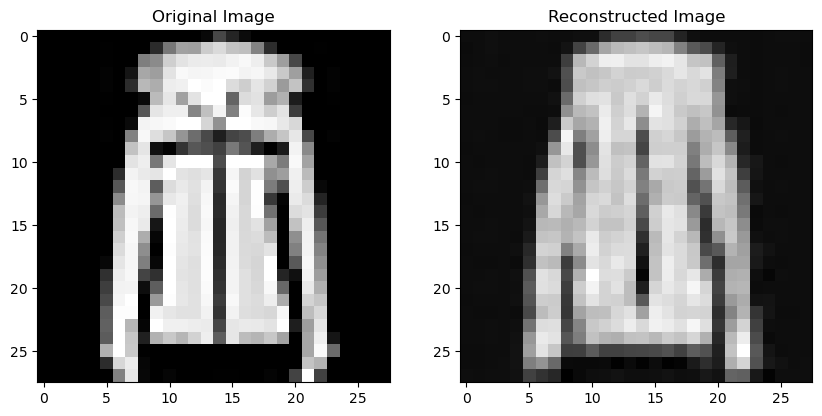

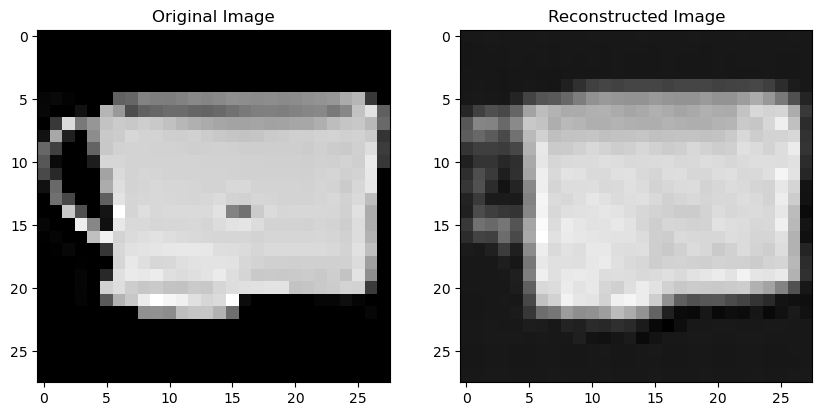

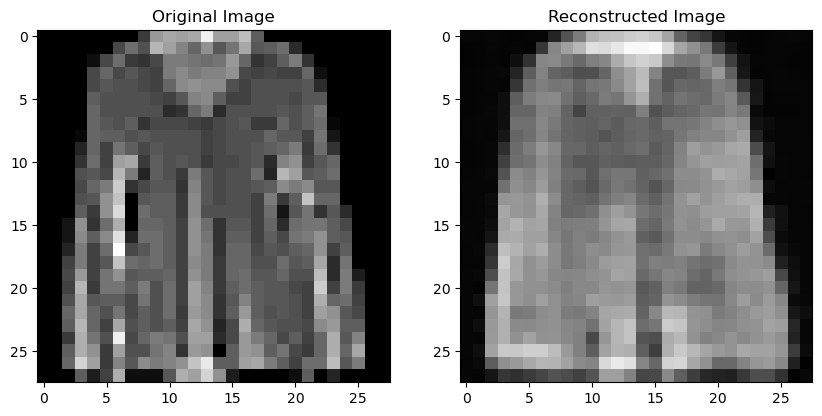

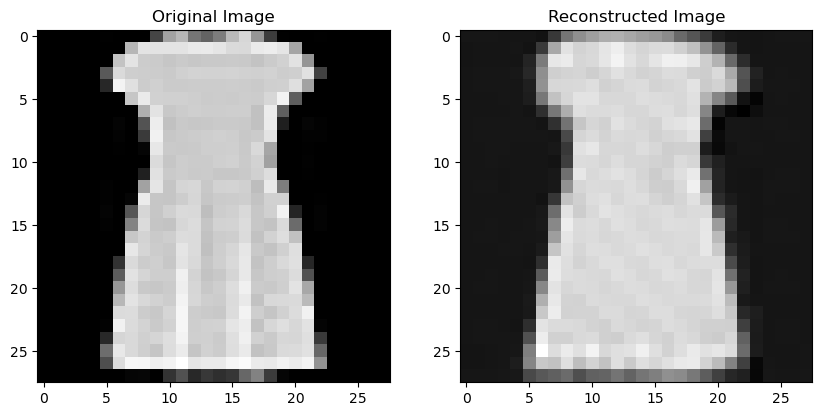

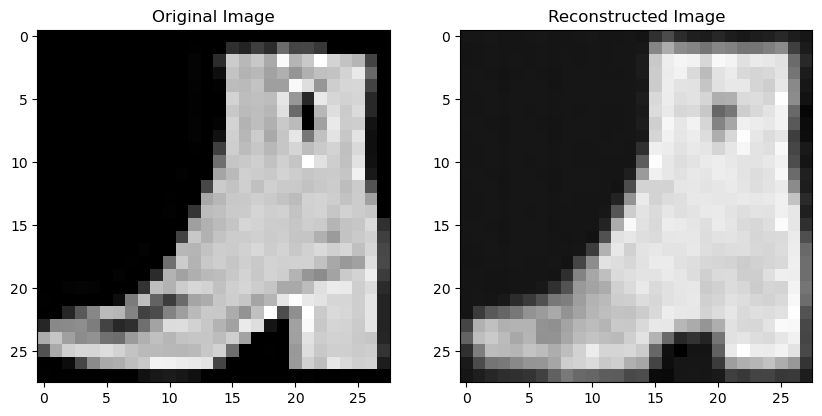

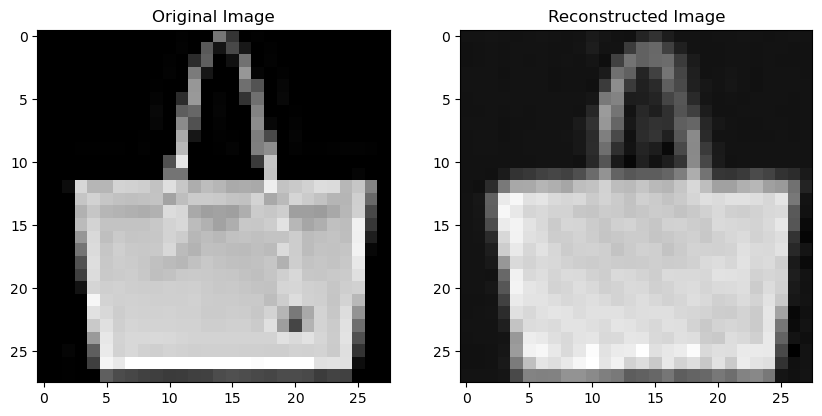

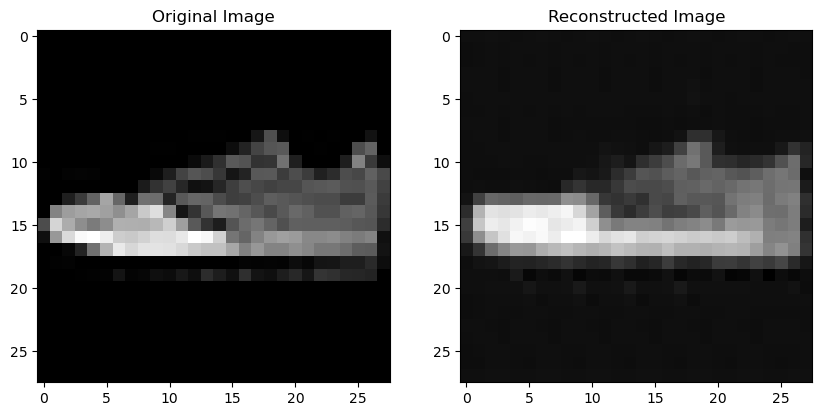

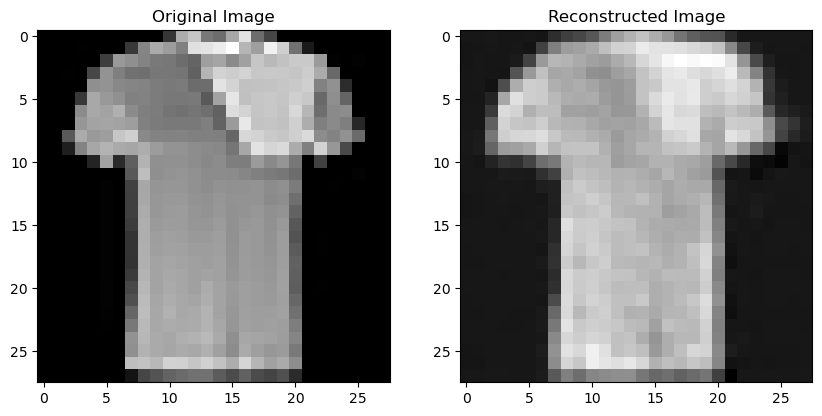

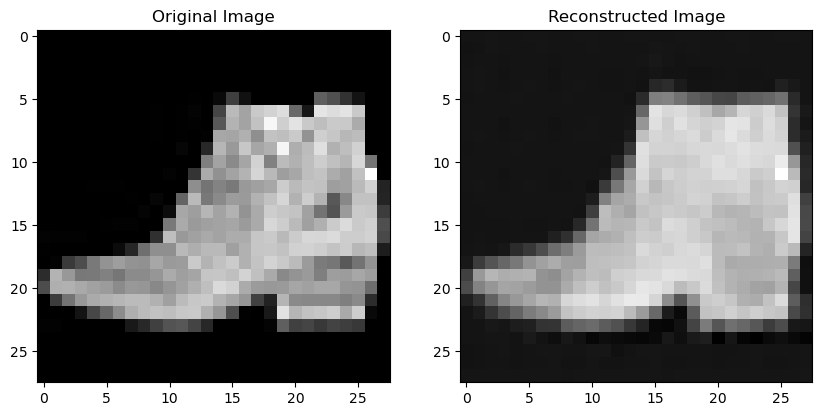

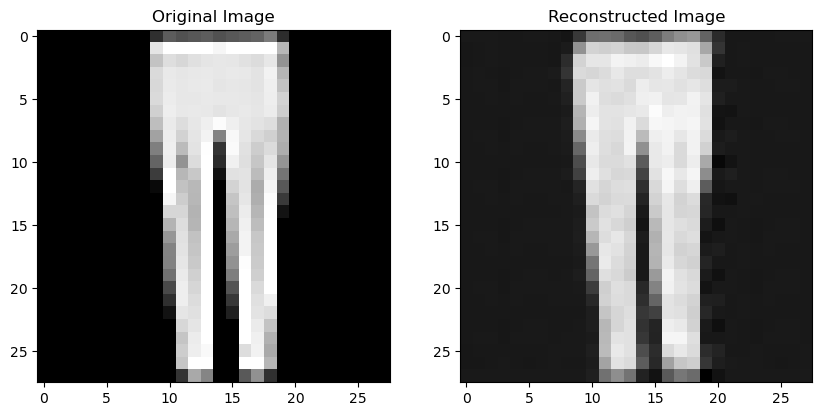

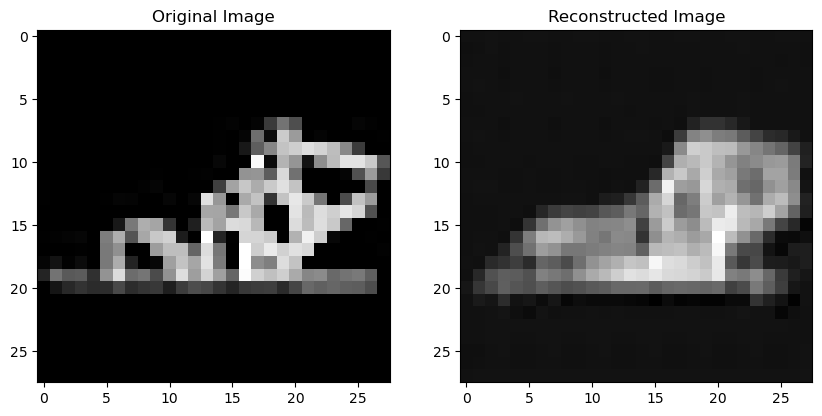

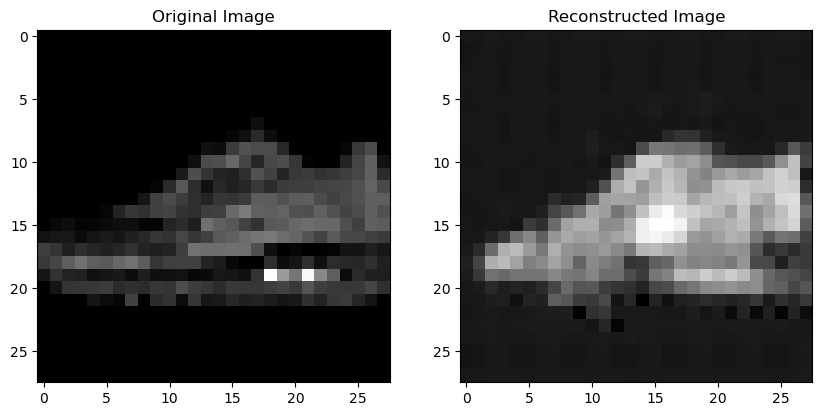

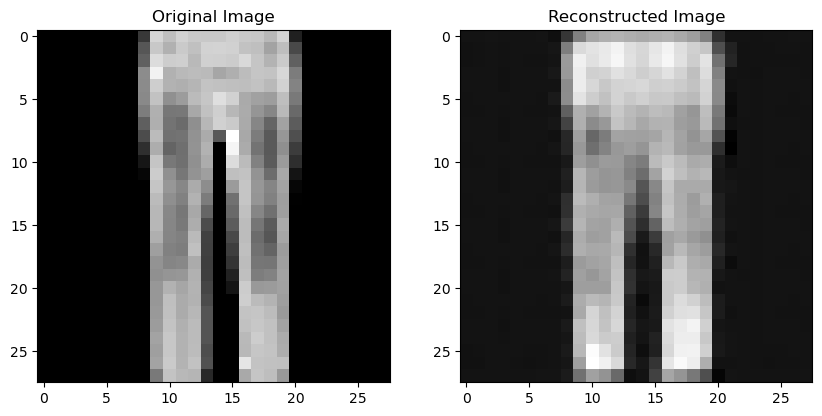

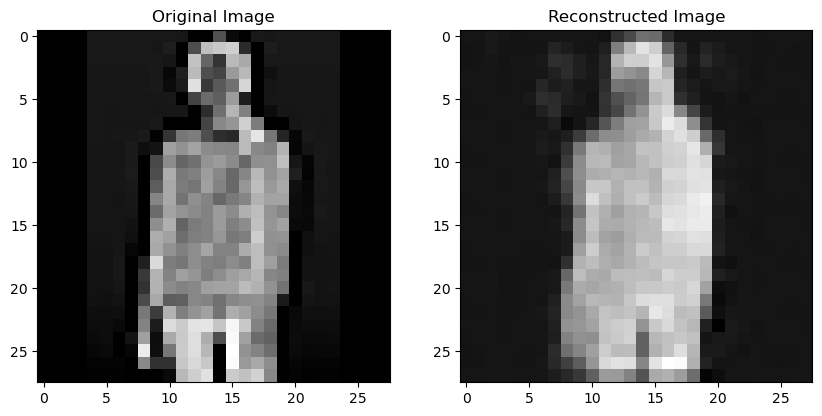

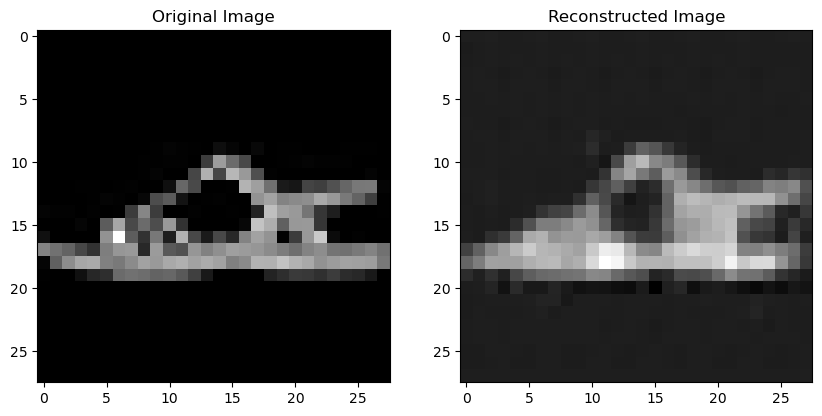

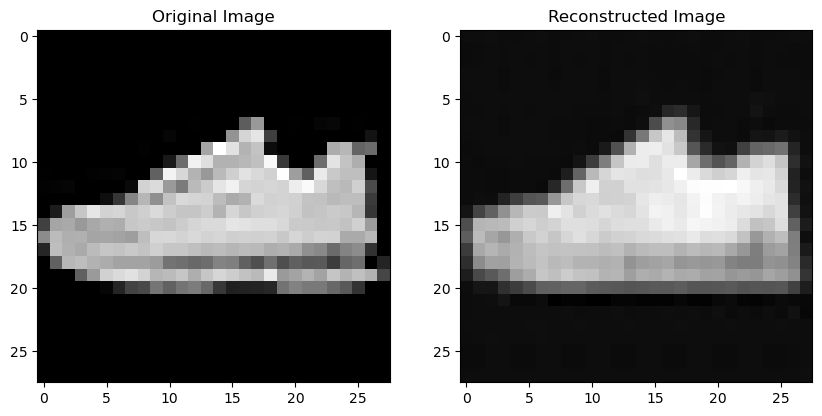

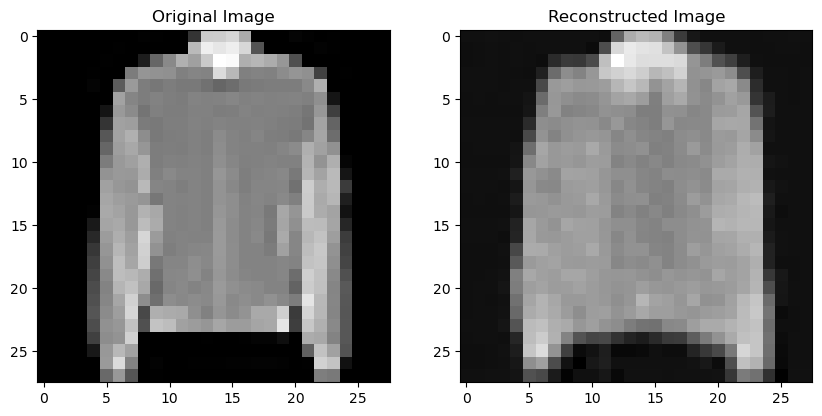

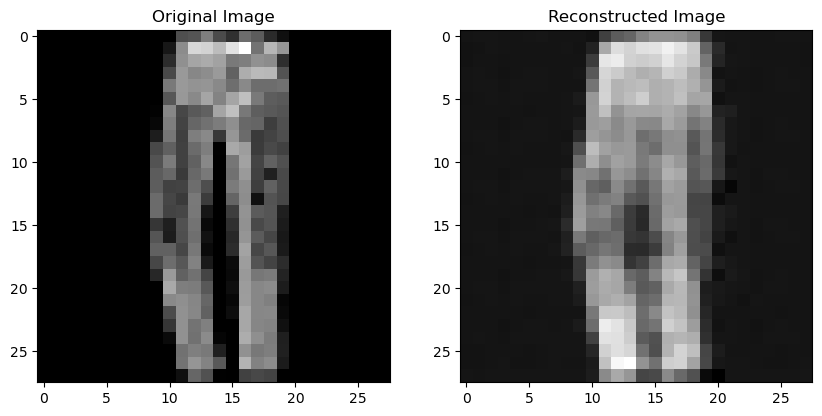

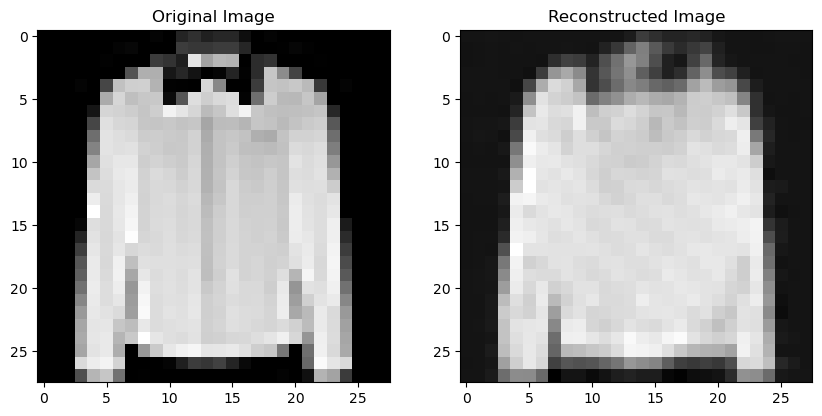

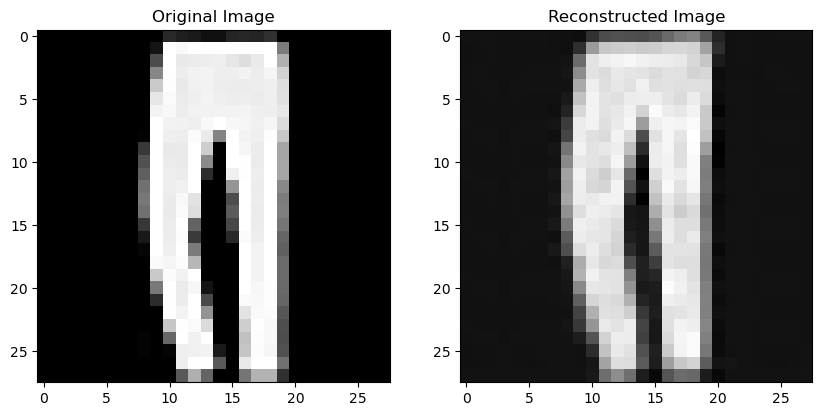

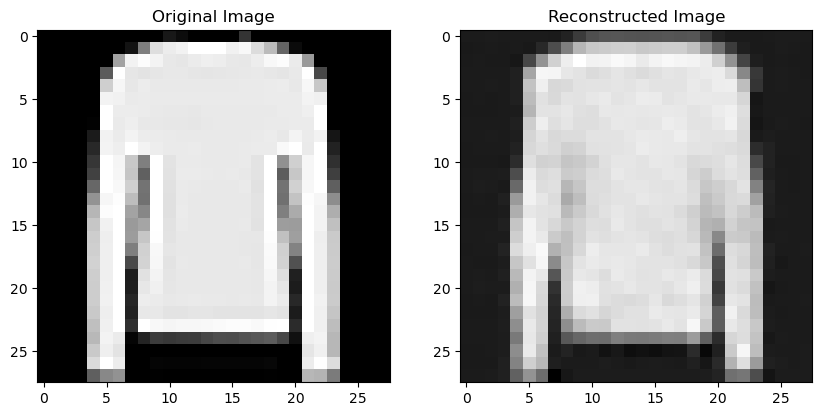

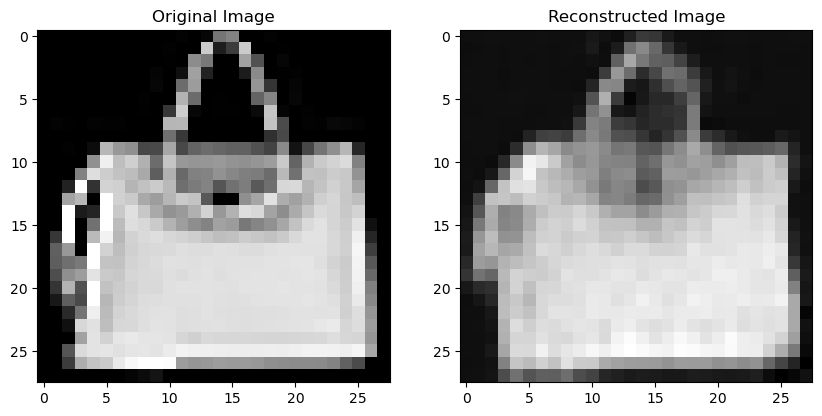

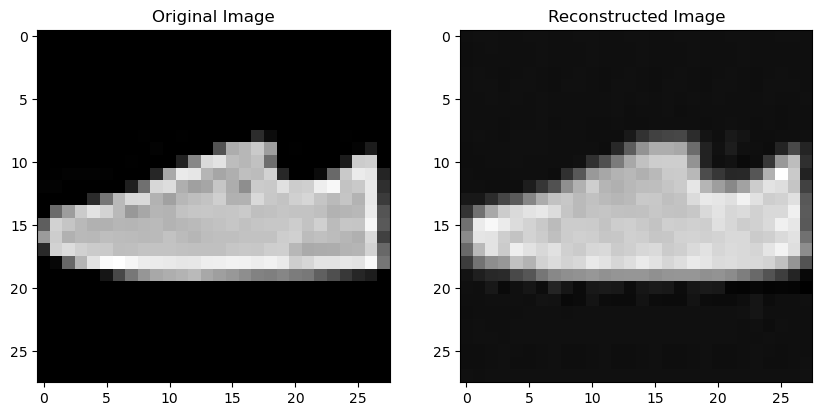

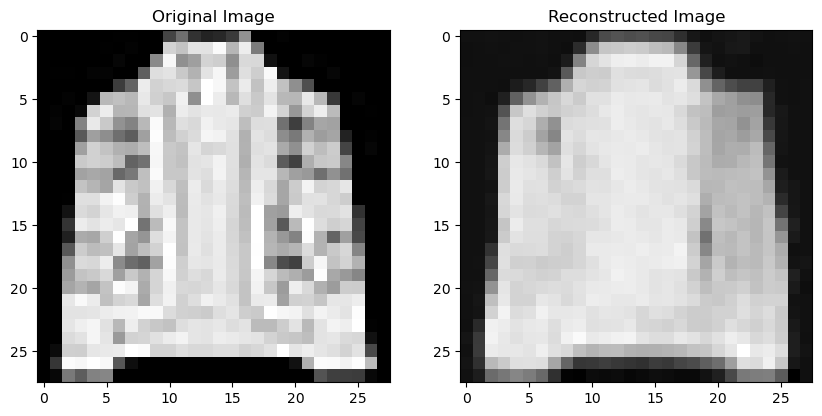

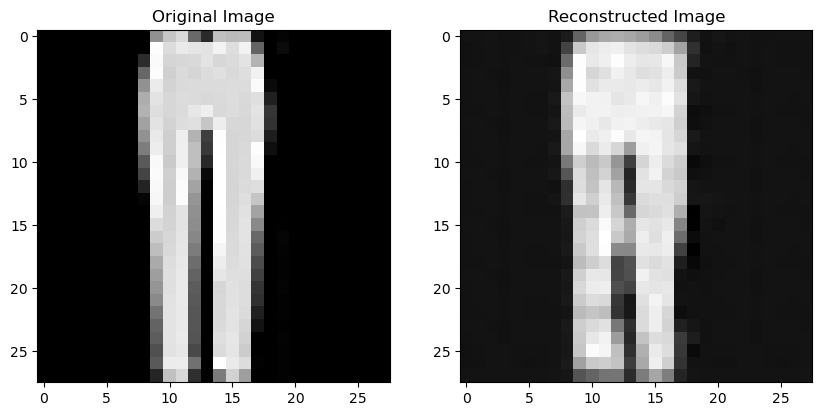

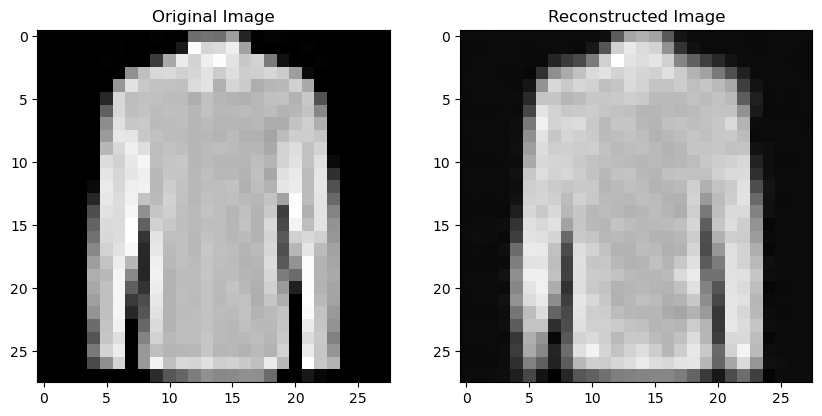

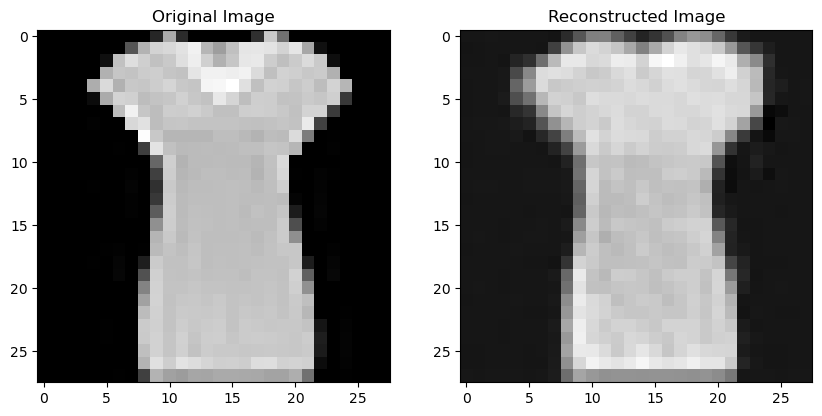

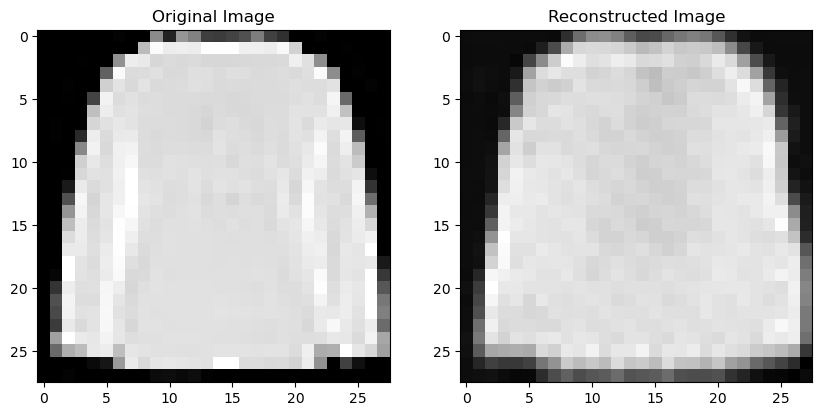

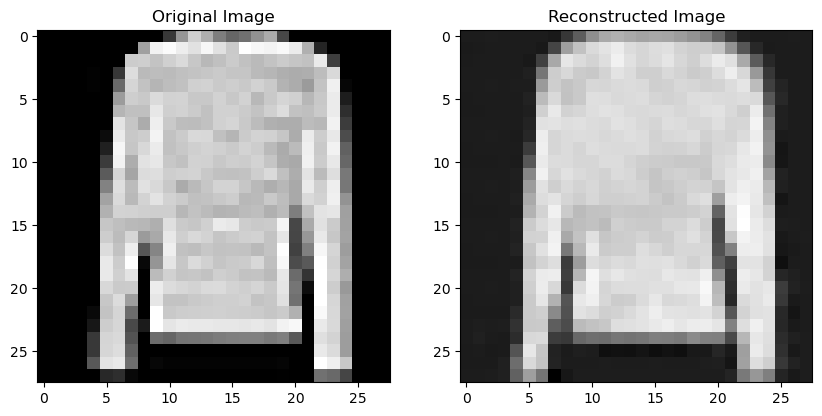

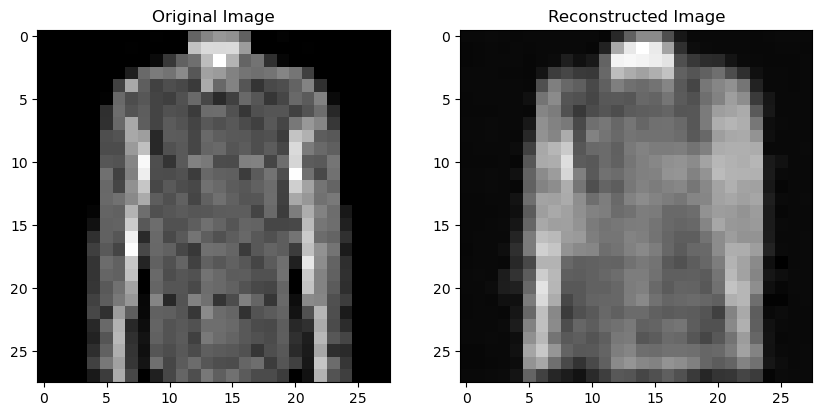

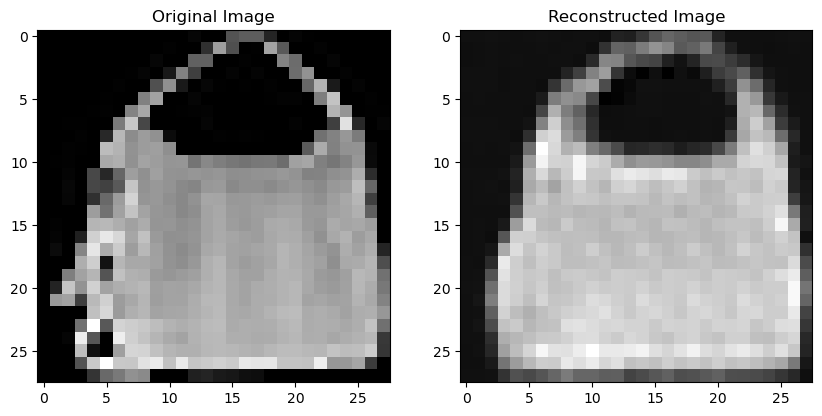

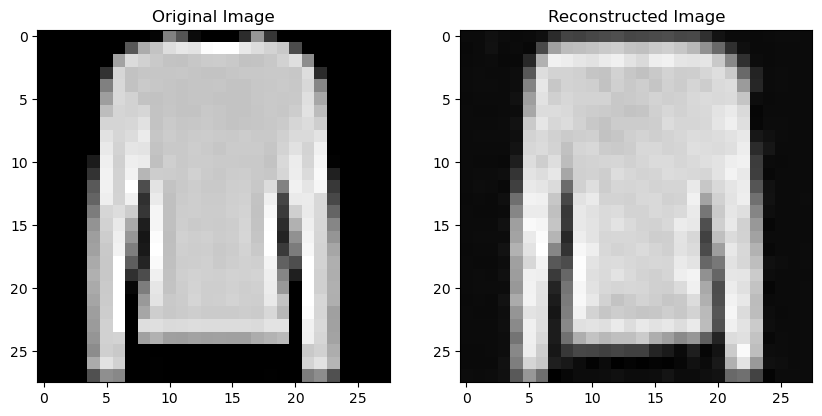

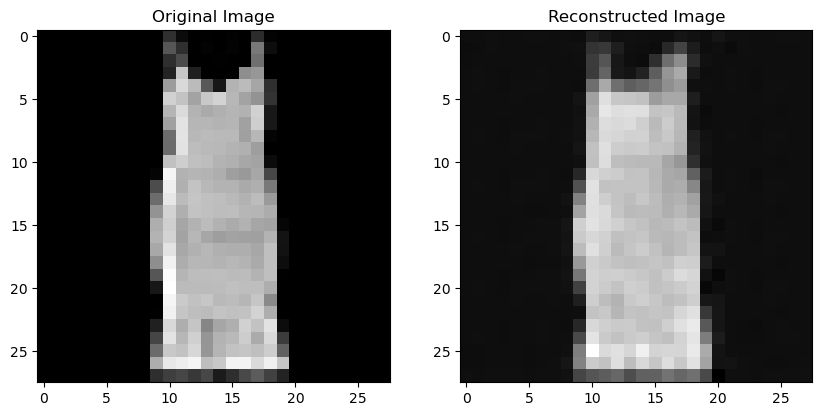

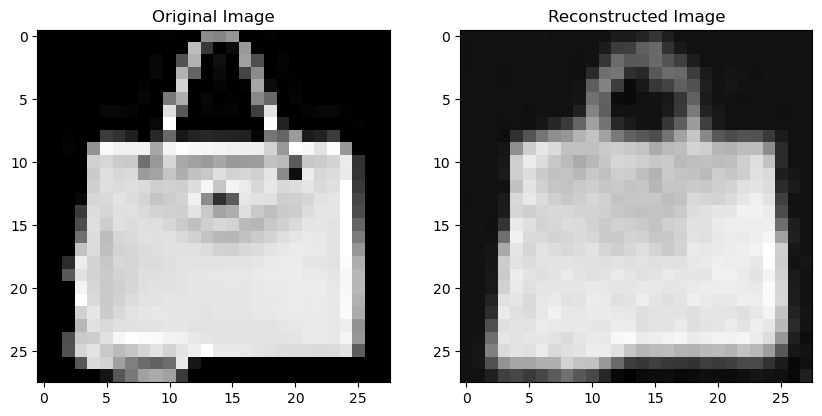

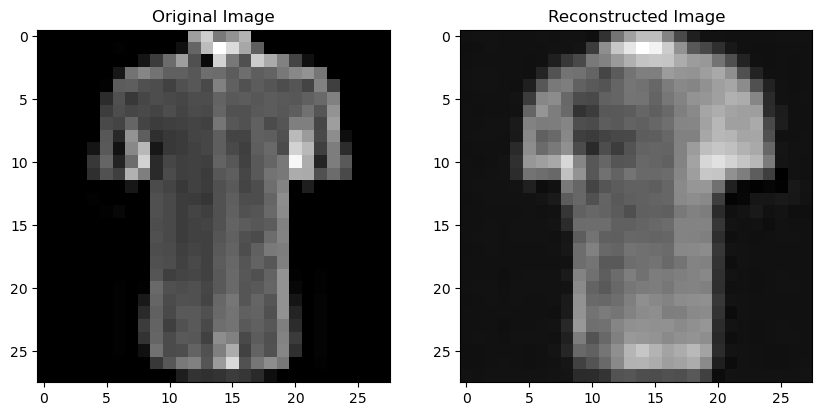

In [157]:
evaluate_vqvae(vqvae, test_loader, device=device)